barrier_mask cells: 8684
channel_mask cells: 15090
basin_mask cells: 17919
Wind barriers (ranges): 50
Wind channels (valleys): 21
Basins / bowls: 277


/var/folders/w2/tldkxgz91wv5m9cdyx8l4gp80000gp/T/ipykernel_18748/953214442.py:1404: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab10", 4)


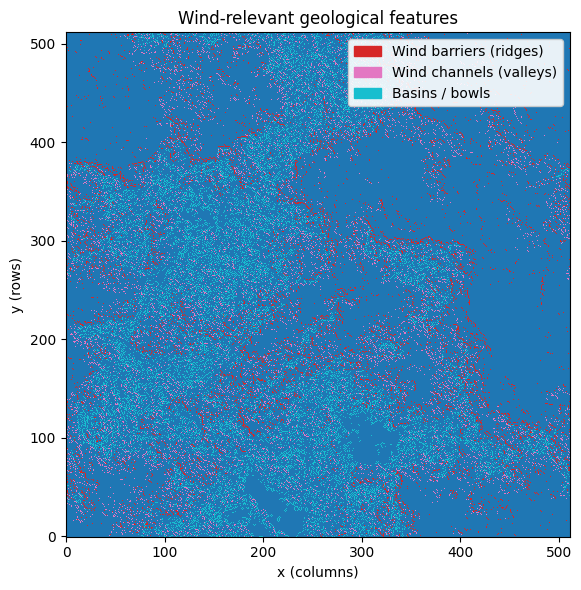

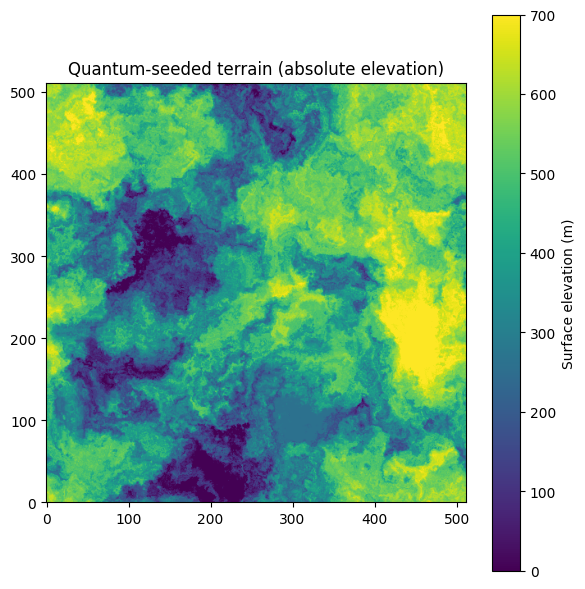

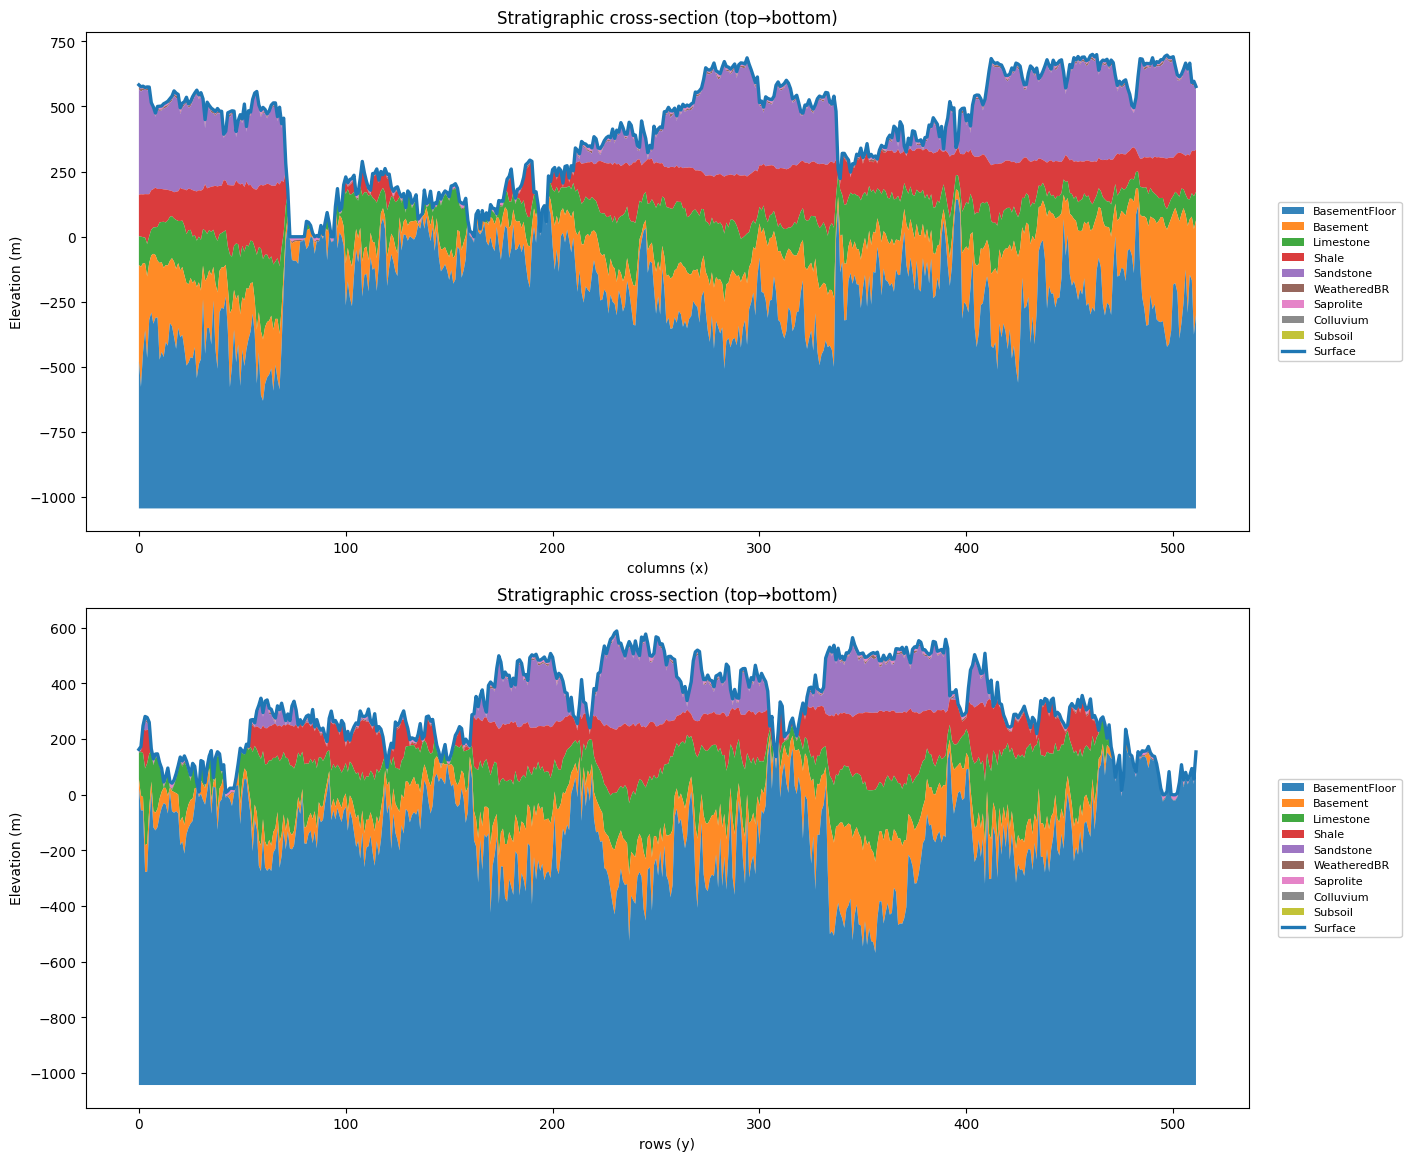

In [1]:
#!/usr/bin/env python3
"""
Realistic terrain + stratigraphy (now three plots):
- Surface elevation map
- One stratigraphic cross-section along X (constant row)
- One stratigraphic cross-section along Y (constant column)




Layer order (top -> bottom):
Topsoil, Subsoil, Colluvium, Saprolite, WeatheredBR (rind/grus),
Sandstone, Shale, Limestone, Basement, BasementFloor
(+ Alluvium & other deposits initialized but not plotted)
"""
from __future__ import annotations





 
# ------------------------- Standard imports -------------------------
import numpy as np
import matplotlib.pyplot as plt





# Optional quantum seeding (no auto-install)
try:
    import qiskit  # noqa
    try:
        import qiskit_aer  # noqa
        HAVE_QISKIT = True
    except Exception:
        HAVE_QISKIT = False
except Exception:
    HAVE_QISKIT = False





# --------------------------- RNG utilities ---------------------------
def qrng_uint32(n, nbits=32):
  """Return n uint32 from Qiskit Aer if available; else PRNG fallback."""
  if not HAVE_QISKIT:
      return np.random.default_rng().integers(0, 2**32, size=n, dtype=np.uint32)
  from qiskit import QuantumCircuit
  try:
      from qiskit_aer import Aer
  except Exception:
      try:
          from qiskit import Aer
      except Exception:
          return np.random.default_rng().integers(0, 2**32, size=n, dtype=np.uint32)
  qc = QuantumCircuit(nbits, nbits)
  qc.h(range(nbits)); qc.measure(range(nbits), range(nbits))
  backend = Aer.get_backend("qasm_simulator")
  import os
  seed_sim = int.from_bytes(os.urandom(4), "little")
  job = backend.run(qc, shots=n, memory=True, seed_simulator=seed_sim)
  mem = job.result().get_memory(qc)
  return np.array([np.uint32(int(bits[::-1], 2)) for bits in mem], dtype=np.uint32)




def rng_from_qrng(n_seeds=4, random_seed=None):
  """Random per run if random_seed=None; reproducible if you pass an int."""
  if random_seed is not None:
      return np.random.default_rng(int(random_seed))
  import os, time, hashlib
  seeds = qrng_uint32(n_seeds).tobytes()
  mix = seeds + os.urandom(16) + int(time.time_ns()).to_bytes(8, "little")
  h = hashlib.blake2b(mix, digest_size=8).digest()
  return np.random.default_rng(int.from_bytes(h, "little"))

# ------------------------ Terrain primitives ------------------------
def fractional_surface(N, beta=3.1, rng=None):
  """Power-law spectrum; higher beta => smoother large-scale terrain."""
  rng = rng or np.random.default_rng()
  kx = np.fft.fftfreq(N); ky = np.fft.rfftfreq(N)
  K = np.sqrt(kx[:, None]**2 + ky[None, :]**2); K[0, 0] = np.inf
  amp = 1.0 / (K ** (beta/2))
  phase = rng.uniform(0, 2*np.pi, size=(N, ky.size))
  spec = amp * (np.cos(phase) + 1j*np.sin(phase)); spec[0, 0] = 0.0
  z = np.fft.irfftn(spec, s=(N, N), axes=(0, 1))
  lo, hi = np.percentile(z, [2, 98])
  return np.clip((z - lo)/(hi - lo + 1e-12), 0, 1)


def bilinear_sample(img, X, Y):
  N = img.shape[0]
  x0 = np.floor(X).astype(int) % N; y0 = np.floor(Y).astype(int) % N
  x1 = (x0+1) % N; y1 = (y0+1) % N
  dx = X - np.floor(X); dy = Y - np.floor(Y)
  return ((1-dx)*(1-dy)*img[x0,y0] + dx*(1-dy)*img[x1,y0] +
          (1-dx)*dy*img[x0,y1] + dx*dy*img[x1,y1])


def domain_warp(z, rng, amp=0.12, beta=3.0):
  """Coordinate distortion; amp↑ => gnarlier micro-relief."""
  N = z.shape[0]
  u = fractional_surface(N, beta=beta, rng=rng)*2 - 1
  v = fractional_surface(N, beta=beta, rng=rng)*2 - 1
  ii, jj = np.meshgrid(np.arange(N), np.arange(N), indexing="ij")
  Xw = (ii + amp*N*u) % N; Yw = (jj + amp*N*v) % N
  return bilinear_sample(z, Xw, Yw)


def ridged_mix(z, alpha=0.18):
  """Ridge/valley sharpening; alpha↑ => craggier."""
  ridged = 1.0 - np.abs(2.0*z - 1.0)
  out = (1-alpha)*z + alpha*ridged
  lo, hi = np.percentile(out, [2, 98])
  return np.clip((out - lo)/(hi - lo + 1e-12), 0, 1)


# Optional global low-pass (smoothness control; default: off)
def lowpass2d(z, cutoff=None, rolloff=0.08):
    """Set cutoff (0..0.5) for smoothing; None disables."""
    if cutoff is None:
        return z
    Nx, Ny = z.shape
    Z = np.fft.rfft2(z)
    kx = np.fft.fftfreq(Nx)[:, None]
    ky = np.fft.rfftfreq(Ny)[None, :]
    r = np.sqrt(kx**2 + ky**2)

    m = np.ones_like(r)
    r0, w = float(cutoff), float(rolloff)
    in_roll = (r > r0) & (r < r0 + w)
    m[r >= r0 + w] = 0.0
    m[in_roll] = 0.5 * (1 + np.cos(np.pi * (r[in_roll] - r0) / w))

    zf = np.fft.irfft2(Z * m, s=z.shape)
    lo, hi = np.percentile(zf, [2, 98])
    return np.clip((zf - lo) / (hi - lo + 1e-12), 0, 1)


# Optional small Gaussian blur (last-mile softness; default: off)
def gaussian_blur(z, sigma=None):
  if sigma is None or sigma <= 0: return z
  rad = int(np.ceil(3*sigma)); x = np.arange(-rad, rad+1)
  g = np.exp(-0.5*(x/sigma)**2); g /= g.sum()
  tmp = np.zeros_like(z)
  for i,w in enumerate(g): tmp += w*np.roll(z, i-rad, axis=1)
  out = np.zeros_like(z)
  for i,w in enumerate(g): out += w*np.roll(tmp, i-rad, axis=0)
  lo, hi = np.percentile(out, [2,98])
  return np.clip((out - lo)/(hi - lo + 1e-12), 0, 1)


def quantum_seeded_topography(
  N=512, beta=3.1, warp_amp=0.12, ridged_alpha=0.18,
  *, random_seed=None, smooth_cutoff=None, smooth_rolloff=0.08, post_blur_sigma=None
):
  rng = rng_from_qrng(n_seeds=4, random_seed=random_seed)
  base_low  = fractional_surface(N, beta=beta,     rng=rng)
  base_high = fractional_surface(N, beta=beta-0.4, rng=rng)
  z = 0.65*base_low + 0.35*base_high
  z = domain_warp(z, rng=rng, amp=warp_amp, beta=beta)
  z = ridged_mix(z, alpha=ridged_alpha)
  z = lowpass2d(z, cutoff=smooth_cutoff, rolloff=smooth_rolloff)
  z = gaussian_blur(z, sigma=post_blur_sigma)
  return z, rng


# ---------------------- Stratigraphy utilities ----------------------
def _box_blur(a, k=5):
  if k <= 1: return a
  out = a.copy()
  for axis in (0,1):
      tmp = out; s = np.zeros_like(tmp)
      for i in range(-(k//2), k//2+1): s += np.roll(tmp, i, axis=axis)
      out = s/float(k)
  return out


def _normalize(x, eps=1e-12):
  lo, hi = np.percentile(x, [2,98])
  return np.clip((x - lo)/(hi - lo + eps), 0.0, 1.0)

# --------------- Wind-relevant geological features -------------------
def compute_topo_fields(surface_elev, pixel_scale_m):
    """
    Basic topographic fields from elevation only.

    Returns dict with:
      E, E_norm          : elevation (m) and normalized (0..1)
      dEx, dEy           : gradients in x (cols) and y (rows) (m/m)
      slope_mag, slope_norm
      aspect             : downslope direction (radians, 0 = +x)
      laplacian          : convex/concave indicator
    """
    E = surface_elev
    E_norm = _normalize(E)

    # gradient: np.gradient returns [d/drow, d/dcol] = [y, x]
    dEy, dEx = np.gradient(E, pixel_scale_m, pixel_scale_m)
    slope_mag = np.hypot(dEx, dEy) + 1e-12
    slope_norm = _normalize(slope_mag)

    # downslope aspect (for windward/leeward logic later)
    aspect = np.arctan2(-dEy, -dEx)

    # simple 4-neighbor Laplacian: <0 convex (ridge), >0 concave (valley)
    up    = np.roll(E, -1, axis=0)
    down  = np.roll(E,  1, axis=0)
    left  = np.roll(E,  1, axis=1)
    right = np.roll(E, -1, axis=1)
    lap = (up + down + left + right - 4.0 * E) / (pixel_scale_m**2)

    return {
        "E": E,
        "E_norm": E_norm,
        "dEx": dEx,
        "dEy": dEy,
        "slope_mag": slope_mag,
        "slope_norm": slope_norm,
        "aspect": aspect,
        "laplacian": lap,
    }


def classify_windward_leeward(dEx, dEy, slope_norm,
                              base_wind_dir_deg,
                              slope_min=0.15):
    """
    Per-cell windward / leeward classification.

    base_wind_dir_deg : direction FROM WHICH the wind blows (0° = +x, 90° = +y)
    slope_min         : ignore very flat cells
    """
    theta = np.deg2rad(base_wind_dir_deg)
    wx, wy = np.cos(theta), np.sin(theta)   # wind-from unit vector

    # component of gradient along wind-from direction
    # >0: terrain rises into the wind (windward); <0: drops away (leeward)
    up_component = dEx * wx + dEy * wy

    slope_enough = slope_norm >= slope_min
    windward_mask = slope_enough & (up_component > 0.0)
    leeward_mask  = slope_enough & (up_component < 0.0)

    return windward_mask, leeward_mask, up_component

def classify_wind_barriers(E_norm, slope_norm, laplacian, up_component,
                           elev_thresh=0.5,
                           slope_thresh=0.4,
                           convex_frac=0.4,
                           up_quantile=0.4):
    """
    Wind barriers: mountain walls that strongly lift/deflect flow.

    Conditions (now a bit looser):
      - moderately high elevation (E_norm >= elev_thresh)
      - moderately steep slopes (slope_norm >= slope_thresh)
      - convex curvature (ridge-like)
      - reasonably strong upslope component along wind
    """
    # convex threshold (more negative laplacian = more ridge-like)
    lap_convex_thr = np.quantile(laplacian, convex_frac)

    # only consider positive upslope; choose upper quantile as "strong" barrier
    mask_pos = up_component > 0.0
    if np.any(mask_pos):
        up_thr = np.quantile(up_component[mask_pos], up_quantile)
    else:
        up_thr = 0.0  # fallback: any positive upslope can count

    barrier_mask = (
        (E_norm      >= elev_thresh) &
        (slope_norm  >= slope_thresh) &
        (laplacian   <= lap_convex_thr) &
        (up_component >= up_thr)
    )
    return barrier_mask

def classify_wind_channels(E_norm, slope_norm, laplacian,
                           dEx, dEy,
                           base_wind_dir_deg,
                           elev_max=0.7,
                           concave_frac=0.6,
                           slope_min=0.03,
                           slope_max=0.7,
                           align_thresh_deg=45.0):
    """
    Wind channels: valley axes that guide flow.

    Looser conditions:
      - low to mid elevation (E_norm <= elev_max)
      - gentle to moderately steep slopes
      - concave curvature
      - downslope direction roughly ALIGNED with wind direction
    """
    theta = np.deg2rad(base_wind_dir_deg)
    wx, wy = np.cos(theta), np.sin(theta)

    # downslope direction vector
    fx, fy = -dEx, -dEy
    magf = np.hypot(fx, fy) + 1e-12
    fxu, fyu = fx / magf, fy / magf

    # cosine of angle between downslope and wind direction
    cos_ang = fxu * wx + fyu * wy
    cos_align = np.cos(np.deg2rad(align_thresh_deg))

    # concave valleys
    lap_concave_thr = np.quantile(laplacian, concave_frac)

    channel_mask = (
        (E_norm      <= elev_max) &
        (slope_norm  >= slope_min) &
        (slope_norm  <= slope_max) &
        (laplacian   >= lap_concave_thr) &
        (cos_ang     >= cos_align)
    )
    return channel_mask


def classify_basins(E_norm, slope_norm, laplacian,
                    elev_max=0.5,
                    slope_max=0.3,
                    concave_frac=0.6):
    """
    Basins / bowls:
      - relatively low elevation
      - gentle slopes
      - concave (bowls)
    (Looser thresholds so we actually catch some.)
    """
    lap_concave_thr = np.quantile(laplacian, concave_frac)
    basin_mask = (
        (E_norm      <= elev_max) &
        (slope_norm  <= slope_max) &
        (laplacian   >= lap_concave_thr)
    )
    return basin_mask


def extract_region_summaries(mask, surface_elev, pixel_scale_m, min_cells=3):
    """
    Connected-component labeling for a boolean mask.

    Uses 8-neighbor connectivity so long skinny ridges/valleys are treated
    as single structures instead of many tiny diagonal fragments.

    Each region becomes a 'structure' with:
      - indices        : (N_i, 2) array of (row, col)
      - centroid_rc    : (row, col) center
      - size_cells     : area in cells
      - mean/max/min elevation, relief
      - orientation_rad: main axis orientation (0 = +x)
      - length_scale_m : rough length along main axis (m)
    """
    ny, nx = mask.shape
    visited = np.zeros_like(mask, dtype=bool)
    regions = []

    for r0 in range(ny):
        for c0 in range(nx):
            if not mask[r0, c0] or visited[r0, c0]:
                continue

            # flood-fill with 8-neighbor connectivity
            stack = [(r0, c0)]
            visited[r0, c0] = True
            cells = []

            while stack:
                r, c = stack.pop()
                cells.append((r, c))

                for dr in (-1, 0, 1):
                    for dc in (-1, 0, 1):
                        if dr == 0 and dc == 0:
                            continue
                        rr, cc = r + dr, c + dc
                        if (
                            0 <= rr < ny and 0 <= cc < nx and
                            mask[rr, cc] and not visited[rr, cc]
                        ):
                            visited[rr, cc] = True
                            stack.append((rr, cc))

            idxs = np.array(cells, dtype=int)
            if idxs.shape[0] < min_cells:
                continue

            rows = idxs[:, 0].astype(float)
            cols = idxs[:, 1].astype(float)
            centroid_r = rows.mean()
            centroid_c = cols.mean()

            vals = surface_elev[idxs[:, 0], idxs[:, 1]]
            mean_e = float(vals.mean())
            max_e  = float(vals.max())
            min_e  = float(vals.min())
            relief = max_e - min_e

            # PCA for main axis orientation / length
            x = cols - centroid_c
            y = rows - centroid_r
            C = np.cov(np.vstack([x, y]))
            eigvals, eigvecs = np.linalg.eigh(C)
            i_max = int(np.argmax(eigvals))
            v = eigvecs[:, i_max]
            orientation = float(np.arctan2(v[1], v[0]))
            length_scale = float(2.0 * np.sqrt(max(eigvals[i_max], 0.0)) * pixel_scale_m)

            regions.append({
                "indices": idxs,
                "centroid_rc": (float(centroid_r), float(centroid_c)),
                "size_cells": int(idxs.shape[0]),
                "mean_elev_m": mean_e,
                "max_elev_m": max_e,
                "min_elev_m": min_e,
                "relief_m": relief,
                "orientation_rad": orientation,
                "length_scale_m": length_scale,
            })

    return regions


def build_wind_structures(surface_elev, pixel_scale_m, base_wind_dir_deg):
    """
    Given a topography map, classify only geological structures that change wind:
      - windward / leeward slopes
      - wind barriers (mountain walls)
      - wind channels (valley corridors)
      - basins / bowls (air pooling zones)

    Returns a dict with per-cell masks and grouped regions.
    Does NOT modify terrain or simulate weather.
    """
    topo = compute_topo_fields(surface_elev, pixel_scale_m)
    E        = topo["E"]
    E_norm   = topo["E_norm"]
    dEx      = topo["dEx"]
    dEy      = topo["dEy"]
    slope_n  = topo["slope_norm"]
    aspect   = topo["aspect"]
    lap      = topo["laplacian"]

    windward_mask, leeward_mask, up_component = classify_windward_leeward(
        dEx, dEy, slope_n, base_wind_dir_deg
    )

    barrier_mask = classify_wind_barriers(
        E_norm, slope_n, lap, up_component
    )

    channel_mask = classify_wind_channels(
        E_norm, slope_n, lap, dEx, dEy, base_wind_dir_deg
    )

    basin_mask = classify_basins(
        E_norm, slope_n, lap
    )

    barrier_regions = extract_region_summaries(barrier_mask, E, pixel_scale_m, min_cells=10)
    channel_regions = extract_region_summaries(channel_mask, E, pixel_scale_m, min_cells=10)
    basin_regions   = extract_region_summaries(basin_mask,   E, pixel_scale_m, min_cells=10)


    return {
        "E": E,
        "E_norm": E_norm,
        "slope_norm": slope_n,
        "aspect": aspect,
        "laplacian": lap,

        "windward_mask": windward_mask,
        "leeward_mask": leeward_mask,
        "up_component": up_component,

        "barrier_mask": barrier_mask,
        "channel_mask": channel_mask,
        "basin_mask": basin_mask,

        "barrier_regions": barrier_regions,   # mountain walls that block/deflect flow
        "channel_regions": channel_regions,   # valley corridors that funnel flow
        "basin_regions": basin_regions,       # bowls where air/storms pool

        "meta": {
            "pixel_scale_m": pixel_scale_m,
        },
    }


# -------------------- Wind / pseudo-low-pressure helpers --------------------
def compute_orographic_low_pressure(
    surface_elev,
    rng,
    pixel_scale_m,
    base_wind_dir_deg=45.0,
    mode="day",               # "day" ~ valley breeze, "night" ~ mountain breeze, "mixed"
    smooth_scale_rel=0.20,    # fraction of domain for large-scale smoothing
):
    """
    Build a 0..1 'low-pressure likelihood' map over mountains WITHOUT
    explicitly storing pressure, using only terrain geometry + wind direction.

    Concept:
    - Wind is driven from higher-pressure to lower-pressure areas.
      We don't model pressure; instead we mark where low-pressure *would* occur
      (ridges on windward side, heated slopes by day, cold pooled valleys at night).
    - Mountains force air to rise on windward slopes => effective low-P there.
    - Daytime: valley breeze -> upslope flow, low-P near heated slopes & ridges.
    - Nighttime: mountain breeze -> downslope flow, low-P in cold pooled valleys.

    Inputs
    ------
    surface_elev : 2D array of absolute elevation (m)
    rng          : np.random.Generator (Qiskit-seeded in your code)
    pixel_scale_m: grid spacing (m)
    base_wind_dir_deg : mean large-scale wind direction *from which* air comes
                        (0° = +x, 90° = +y)
    mode         : "day", "night", or "mixed"
    smooth_scale_rel : how coarse the large-scale basin/high field is (0..1)
    """
    z = surface_elev
    ny, nx = z.shape

    # --- gradient & slope ---
    dzdx, dzdy = np.gradient(z, pixel_scale_m, pixel_scale_m)
    slope_mag = np.sqrt(dzdx**2 + dzdy**2) + 1e-12
    slope_n   = _normalize(slope_mag)
    gentle    = 1.0 - slope_n

    # --- basic elevation normalization / basins vs highs ---
    z_smooth_k = max(5, int(smooth_scale_rel * min(nx, ny)) | 1)
    z_smooth   = _box_blur(z, k=z_smooth_k)

    elev_n = _normalize(z)            # 0 low → 1 high
    highs  = _normalize(z_smooth)     # broad highs (ridges, plateaus)
    basins = _normalize(1.0 - z_smooth)  # broad valleys/depressions

    # --- large-scale wind direction (unit vector) ---
    # wind blows from this direction into the domain
    az = np.deg2rad(base_wind_dir_deg)
    wx, wy = np.cos(az), np.sin(az)

    # directional derivative of elevation along wind direction:
    # positive where flow goes upslope (orographic lifting on windward side)
    dzw = dzdx * wx + dzdy * wy
    orographic_raw = np.maximum(dzw, 0.0)   # only upslope component
    orographic = _normalize(orographic_raw)

    # --- valley vs mountain breeze components ---
    # day: slopes heated, air rises -> low-P along sun-facing + valley-slopes
    # night: air cools, drains into valleys -> low-P pooled in basins

    # treat "sun direction" similar to wind_dir for now; you can make it separate later
    sx, sy = wx, wy
    dzs = dzdx * sx + dzdy * sy
    sun_slope_raw = np.maximum(dzs, 0.0)    # slopes facing the "sun"
    sun_slope = _normalize(sun_slope_raw)

    # Daytime valley-breeze low-P:
    # - on heated, sun-facing slopes (sun_slope)
    # - near ridge tops / high terrain (highs)
    lowP_day = _normalize(0.5 * sun_slope + 0.5 * highs)

    # Nighttime mountain-breeze low-P:
    # - in basins/valleys (basins)
    # - where slopes are gentle (cold air accumulates more easily)
    lowP_night = _normalize(0.7 * basins + 0.3 * gentle)

    # --- combine with orographic lifting (always present if mountains + wind) ---
    mode = str(mode).lower()
    if mode == "day":
        lowP = 0.50 * orographic + 0.50 * lowP_day
    elif mode == "night":
        lowP = 0.40 * orographic + 0.60 * lowP_night
    else:  # "mixed"
        lowP = 0.40 * orographic + 0.30 * lowP_day + 0.30 * lowP_night

    # small quantum-random perturbation, smoothed so it doesn't make 'salt & pepper'
    k_noise = max(7, int(0.05 * min(nx, ny)) | 1)
    rnd = rng.standard_normal(size=z.shape)
    rnd_smooth = _box_blur(rnd, k=k_noise)
    rnd_smooth = rnd_smooth / (np.std(rnd_smooth) + 1e-9)

    lowP += 0.15 * rnd_smooth  # gentle perturbation
    lowP = _normalize(lowP)

    return lowP  # 0..1: higher = more likely effective low-pressure zone


# ---------------- Physics-informed near-surface layers ----------------
def soil_thickness_from_slope(z_norm, soil_range_m=(0.3, 1.8)):
  dzdx, dzdy = np.gradient(z_norm)
  slope_mag = np.sqrt(dzdx**2 + dzdy**2)
  slope_n   = _normalize(slope_mag)
  t = soil_range_m[1] - (soil_range_m[1] - soil_range_m[0]) * slope_n
  return _box_blur(t, k=5)


def colluvium_thickness_field(
  z_norm, rng, pixel_scale_m,
  colluvium_max_m=18.0,
  *,
  w_gentle=0.35, w_curv=0.30, w_low=0.20, w_twi=0.15,
  smooth_relief_px=31, twi_k1=7, twi_k2=13,
  lognorm_sigma=0.20, floor_m=0.5, bias=1.0
):
  dzdx, dzdy = np.gradient(z_norm)
  slope_mag = np.sqrt(dzdx**2 + dzdy**2)
  slope_n   = _normalize(slope_mag)
  gentle    = 1.0 - slope_n
  d2x,_ = np.gradient(dzdx); _,d2y = np.gradient(dzdy)
  curv  = d2x + d2y
  hollows = _normalize(np.maximum(curv, 0.0))
  k = max(5, int(smooth_relief_px)|1)
  z_smooth = _box_blur(z_norm, k=k)
  lowlands = _normalize(1.0 - z_smooth)
  catch = _box_blur(_box_blur(1.0 - slope_n, k=7), k=13)
  wet = _normalize(catch - slope_n)
  w = np.array([w_gentle, w_curv, w_low, w_twi], float); w = np.clip(w,0,None); w /= (w.sum()+1e-12)
  index = _normalize(w[0]*gentle + w[1]*hollows + w[2]*lowlands + w[3]*wet)
  noise = rng.lognormal(mean=0.0, sigma=float(lognorm_sigma), size=index.shape)
  index_noisy = _normalize(index * noise)
  return bias * (floor_m + index_noisy * (colluvium_max_m - floor_m))


def saprolite_thickness_field(
  z_norm, rng,
  *,
  median_m=6.0, clamp_min=0.5, clamp_max=30.0,
  w_gentle=0.6, w_interfluve=0.4,
  relief_window_px=61, sigma=0.35
):
  dzdx, dzdy = np.gradient(z_norm)
  slope_mag = np.sqrt(dzdx**2 + dzdy**2)
  gentle = 1.0 - _normalize(slope_mag)
  k = max(5, int(relief_window_px)|1)
  z_smooth = _box_blur(z_norm, k=k)
  interfluves = _normalize(z_smooth)
  idx = _normalize(w_gentle*gentle + w_interfluve*interfluves)
  base = np.exp(np.log(median_m) + sigma * rng.standard_normal(size=idx.shape))
  return np.clip(base * (0.4 + 0.6*idx), clamp_min, clamp_max)


def weathered_rind_thickness_field(
  z_norm, rng,
  *,
  median_m=1.8, clamp_min=0.4, clamp_max=6.0,
  patch_beta=3.0, patch_alpha=0.5
):
  N = z_norm.shape[0]
  tex = fractional_surface(N, beta=patch_beta, rng=rng)
  tex = (1 - np.abs(2*tex - 1))
  base = np.exp(np.log(median_m) + 0.25 * rng.standard_normal(size=tex.shape))
  return np.clip((1 - patch_alpha) * base + patch_alpha * base * tex, clamp_min, clamp_max)

# ---------------- Glacial / aeolian deposit thickness fields ----------------
def till_thickness_field(
    z_norm, rng,
    *,
    max_till_m=25.0,
    floor_m=0.0,
    relief_window_px=61,
    lognorm_sigma=0.35,
):
    dzdx, dzdy = np.gradient(z_norm)
    slope_mag = np.sqrt(dzdx**2 + dzdy**2)
    slope_n   = _normalize(slope_mag)
    gentle    = 1.0 - slope_n

    k = max(5, int(relief_window_px) | 1)
    z_smooth = _box_blur(z_norm, k=k)
    basins   = _normalize(1.0 - z_smooth)

    index = _normalize(0.6 * basins + 0.4 * gentle)
    noise = rng.lognormal(mean=0.0, sigma=float(lognorm_sigma), size=index.shape)
    index_noisy = _normalize(index * noise)
    return floor_m + index_noisy * (max_till_m - floor_m)


def loess_thickness_field(
    z_norm, rng,
    *,
    max_loess_m=6.0,
    floor_m=0.0,
    relief_window_px=81,
    lognorm_sigma=0.30,
):
    dzdx, dzdy = np.gradient(z_norm)
    slope_mag = np.sqrt(dzdx**2 + dzdy**2)
    slope_n   = _normalize(slope_mag)
    gentle    = 1.0 - slope_n

    k = max(5, int(relief_window_px) | 1)
    z_smooth = _box_blur(z_norm, k=k)
    uplands  = _normalize(z_smooth)
    mid_uplands = uplands * (1.0 - uplands)

    index = _normalize(0.6 * gentle + 0.4 * mid_uplands)
    noise = rng.lognormal(mean=0.0, sigma=float(lognorm_sigma), size=index.shape)
    index_noisy = _normalize(index * noise)
    return floor_m + index_noisy * (max_loess_m - floor_m)


def dune_thickness_field(
    z_norm, rng,
    *,
    max_dune_m=10.0,
    floor_m=0.0,
    relief_window_px=41,
    lognorm_sigma=0.40,
):
    dzdx, dzdy = np.gradient(z_norm)
    slope_mag = np.sqrt(dzdx**2 + dzdy**2)
    slope_n   = _normalize(slope_mag)
    gentle    = 1.0 - slope_n

    k = max(5, int(relief_window_px) | 1)
    z_smooth = _box_blur(z_norm, k=k)
    lows     = _normalize(1.0 - z_smooth)

    d2x,_ = np.gradient(dzdx); _,d2y = np.gradient(dzdy)
    curv  = d2x + d2y
    convex = _normalize(np.maximum(-curv, 0.0))

    index = _normalize(0.5 * gentle + 0.3 * lows + 0.2 * convex)
    noise = rng.lognormal(mean=0.0, sigma=float(lognorm_sigma), size=index.shape)
    index_noisy = _normalize(index * noise)
    return floor_m + index_noisy * (max_dune_m - floor_m)


# ---------------- Continental crust trend helper ----------------
def crust_thickness_field(surface_elev, elev_range_m, min_factor=2.0, max_factor=5.0):
    """
    Continental-only 'effective crust thickness' field (same shape as surface_elev).
    Encodes only the pattern: higher topography → thicker crustal column.
    """
    span = max(float(elev_range_m), 1e-3)
    zmin = float(surface_elev.min())
    zmax = float(surface_elev.max())
    znorm = (surface_elev - zmin) / (zmax - zmin + 1e-12)  # 0..1
    factor = min_factor + (max_factor - min_factor) * znorm
    return span * factor


# ------------------------ Layered stratigraphy -----------------------
def generate_stratigraphy(
  z_norm, rng,
  elev_range_m=700.0,
  pixel_scale_m=10.0,
  soil_range_m=(0.3, 1.8),
  # Colluvium controls
  colluvium_max_m=18.0,
  wC_gentle=0.35, wC_curv=0.30, wC_low=0.20, wC_twi=0.15,
  C_relief_px=31, C_twi_k1=7, C_twi_k2=13, C_sigma=0.20, C_floor=0.5, C_bias=1.0,
  # Saprolite controls
  sap_median=6.0, sap_min=0.5, sap_max=30.0, sap_w_gentle=0.6, sap_w_inter=0.4, sap_relief_px=61, sap_sigma=0.35,
  # Weathered rind controls
  rind_median=1.8, rind_min=0.4, rind_max=6.0, rind_patch_beta=3.0, rind_patch_alpha=0.5,
  # Competent rock package (relative proportions)
  unit_thickness_m=(90.0,110.0,100.0),  # sandstone, shale, limestone
  undulation_amp_m=10.0, undulation_beta=3.2,
  dip_deg=6.0, dip_dir_deg=45.0,
  burial_depth_m=120.0,
  bed_struct_weight=0.45,
  interface_blur_sigma=None
):
  """
  Build stratigraphy where:
  - Topsoil / Colluvium / Saprolite / WeatheredBR follow hillslope & weathering rules.
  - Sandstone / Shale / Limestone form broad, gently dipping sheets that thicken
    in basins and thin on highs (marine transgression style).
  - Basement provides a smooth crystalline foundation underneath.
  - All randomness uses Qiskit-seeded rng, but is heavily smoothed to avoid 'spiky columns'.
  """
  N = z_norm.shape[0]
  # Absolute elevation (m)
  E = z_norm * elev_range_m

    # ---------- 1) Near-surface regolith ----------
  # Total soil thickness: thicker on low, gentle slopes
  soil_total = soil_thickness_from_slope(z_norm, soil_range_m)

  # Split into Topsoil (A) and Subsoil (B horizon).
  # You can tune top_frac (0.3–0.5) if you want a thicker A horizon.
  top_frac = 0.4
  topsoil_thick  = top_frac * soil_total
  subsoil_thick  = (1.0 - top_frac) * soil_total

  # Colluvium: gravity-driven, thickest at slope bases/hollows/lowlands.
  tC = colluvium_thickness_field(
      z_norm, rng, pixel_scale_m, colluvium_max_m,
      w_gentle=wC_gentle, w_curv=wC_curv, w_low=wC_low, w_twi=wC_twi,
      smooth_relief_px=C_relief_px, twi_k1=C_twi_k1, twi_k2=C_twi_k2,
      lognorm_sigma=C_sigma, floor_m=C_floor, bias=C_bias
  )

  # Saprolite: thick in stable, moderately elevated interfluves.
  tS = saprolite_thickness_field(
      z_norm, rng,
      median_m=sap_median, clamp_min=sap_min, clamp_max=sap_max,
      w_gentle=sap_w_gentle, w_interfluve=sap_w_inter, relief_window_px=sap_relief_px, sigma=sap_sigma
  )

  # Weathered bedrock rind / grus: patchy, overlying basement.
  tR = weathered_rind_thickness_field(
      z_norm, rng,
      median_m=rind_median, clamp_min=rind_min, clamp_max=rind_max,
      patch_beta=rind_patch_beta, patch_alpha=rind_patch_alpha
  )

  # Glacial / aeolian mantles (thickness fields; returned via 'deposits')
  t_till  = till_thickness_field(z_norm, rng)
  t_loess = loess_thickness_field(z_norm, rng)
  t_dune  = dune_thickness_field(z_norm, rng)



  # ---------- 2) Structural plane for sedimentary cover ----------
  ii, jj = np.meshgrid(np.arange(N), np.arange(N), indexing="ij")
  X = ii * pixel_scale_m
  Y = jj * pixel_scale_m
  az  = np.deg2rad(dip_dir_deg)   # map-view azimuth of dip direction
  dip = np.deg2rad(dip_deg)       # dip angle
  ux, uy = np.cos(az), np.sin(az) # unit vector along dip direction

  plane = np.tan(dip) * (ux * X + uy * Y)   # regional dip
  undul = (fractional_surface(N, beta=undulation_beta, rng=rng)*2 - 1) * undulation_amp_m
  bed_struct = plane + undul
  bed_struct_zm = bed_struct - np.mean(bed_struct)


  # ---------- 3) Continental crust & sedimentary thickness trend ----------
  elev_span = float(E.max() - E.min() + 1e-9)
  crust_thick = crust_thickness_field(E, elev_span)  # thicker crust under high topo

  # Assume ~35% of crust_thick is sedimentary cover on continental crust. :contentReference[oaicite:10]{index=10}
  sed_frac  = 0.35
  sed_total = sed_frac * crust_thick

  # Very coarse topographic smooth to define basins vs highs
  k_coarse = max(31, int(0.15 * N) | 1)
  z_smooth = _box_blur(z_norm, k=k_coarse)
  basins   = _normalize(1.0 - z_smooth)   # 1 in lows, 0 on highs
  highs    = _normalize(z_smooth)         # 1 on highs

  # Present slope – steeper = more erosion, so thinner preserved cover.
  dEx, dEy = np.gradient(E)
  slope_mag = np.sqrt(dEx**2 + dEy**2)
  slope_n   = _normalize(slope_mag)
  gentle    = 1.0 - slope_n

  # Facies environments (all 0–1 after _normalize):
  # - Sandstone: shorelines / basin margins → intermediate basinness, some slope. :contentReference[oaicite:11]{index=11}
  sand_env_raw  = basins * (1.0 - basins) * (0.5 + 0.5 * slope_n)
  shale_env_raw = basins                        # deepening into basins (offshore muds).
  lime_env_raw  = highs * gentle                # carbonate platforms on gentle highs. :contentReference[oaicite:12]{index=12}

  sand_env  = _normalize(sand_env_raw)
  shale_env = _normalize(shale_env_raw)
  lime_env  = _normalize(lime_env_raw)

  # Relative vertical proportions from unit_thickness_m
  T_sand, T_shale, T_lime = unit_thickness_m
  total_units = float(T_sand + T_shale + T_lime + 1e-12)
  f_sand  = T_sand  / total_units
  f_shale = T_shale / total_units
  f_lime  = T_lime  / total_units

  # Helper: smoothed random field (quantum-seeded, but laterally coherent)
  def smooth_random_field(k):
      noise = rng.standard_normal(size=E.shape)
      return _box_blur(noise, k=max(5, int(k) | 1))

  k_thick = max(15, int(0.06 * N) | 1)

  # Base thickness fields (trend) for each unit
  base_sand  = sed_total * f_sand  * (0.4 + 0.6 * sand_env)
  base_shale = sed_total * f_shale * (0.3 + 0.7 * shale_env)
  base_lime  = sed_total * f_lime  * (0.3 + 0.7 * lime_env)

  # Quantum-smoothed variability (keeps sheets coherent, avoids "icicles")
  rnd_sand  = smooth_random_field(k_thick)
  rnd_shale = smooth_random_field(k_thick)
  rnd_lime  = smooth_random_field(k_thick)

  def apply_variation(base, rnd, amp=0.3):
      std = float(np.std(rnd) + 1e-9)
      f = 1.0 + amp * (rnd / std)
      f = np.clip(f, 0.5, 1.5)
      return np.clip(base * f, 0.0, None)

  t_sand_trend  = apply_variation(base_sand,  rnd_sand)
  t_shale_trend = apply_variation(base_shale, rnd_shale)
  t_lime_trend  = apply_variation(base_lime,  rnd_lime)

  # Thin units modestly on steep slopes, but never turn them off entirely
  thin_factor = 0.4 + 0.6 * gentle  # 1 on gentle, 0.4 on steep
  t_sand  = t_sand_trend  * thin_factor
  t_shale = t_shale_trend * thin_factor
  t_lime  = t_lime_trend  * thin_factor

  # ---------- 4) Structural tops for Sandstone / Shale / Limestone ----------
  Emean       = float(E.mean())
  crust_mean  = float(crust_thick.mean())
  crust_anom  = (crust_thick - crust_mean) / (crust_mean + 1e-9)

  # Deeper sediment stack under thicker crust (mountain belts), shallower under thinner crust.
  top_sed_ref = (
      (Emean - burial_depth_m)
      - 0.3 * crust_anom * elev_span
      + bed_struct_weight * bed_struct_zm
  )

  top_sandstone_raw = top_sed_ref
  top_shale_raw     = top_sandstone_raw - t_sand
  top_limestone_raw = top_shale_raw     - t_shale
  top_basement_raw  = top_limestone_raw - t_lime  # top of crystalline basement

    # ---------- 5) Regolith stack above rock ----------
  eps = 0.01

  # A and B horizons
  top_topsoil   = E
  top_subsoil   = top_topsoil   - topsoil_thick
  top_colluvium = top_subsoil   - subsoil_thick

  # Colluvium, saprolite, weathered rind
  top_saprolite = top_colluvium - tC
  top_rind      = top_saprolite - tS

  # Ensure rock units stay below weathered rind and respect ordering
  top_sandstone = np.minimum(top_sandstone_raw, top_rind - eps)
  top_shale     = np.minimum(top_shale_raw,     top_sandstone - eps)
  top_limestone = np.minimum(top_limestone_raw, top_shale - eps)
  top_basement  = np.minimum(top_basement_raw,  top_limestone - eps)

  # ---------- 6) Basement floor ----------
  z_floor = float(top_basement.min() - 0.2 * elev_span)
  top_basement_floor = np.full_like(top_basement, z_floor)

  # ---------- 7) Optional smoothing of rock interfaces ----------
  if interface_blur_sigma is not None and interface_blur_sigma > 0:
      def blur(a): return gaussian_blur(a, sigma=interface_blur_sigma)
      top_sandstone = blur(top_sandstone)
      top_shale     = blur(top_shale)
      top_limestone = blur(top_limestone)
      top_basement  = blur(top_basement)
      # Re-enforce ordering after blur
      top_sandstone = np.minimum(top_sandstone, top_rind - eps)
      top_shale     = np.minimum(top_shale,     top_sandstone - eps)
      top_limestone = np.minimum(top_limestone, top_shale - eps)
      top_basement  = np.minimum(top_basement,  top_limestone - eps)
      z_floor = float(top_basement.min() - 0.2 * elev_span)
      top_basement_floor = np.full_like(top_basement, z_floor)

  # ---------- 8) Thickness rasters ----------
  thickness = {
      "Topsoil":       np.maximum(top_topsoil     - top_subsoil,         0.0),
      "Subsoil":       np.maximum(top_subsoil     - top_colluvium,       0.0),
      "Colluvium":     np.maximum(top_colluvium   - top_saprolite,       0.0),
      "Saprolite":     np.maximum(top_saprolite   - top_rind,            0.0),
      "WeatheredBR":   np.maximum(top_rind        - top_sandstone,       0.0),
      "Sandstone":     np.maximum(top_sandstone   - top_shale,           0.0),
      "Shale":         np.maximum(top_shale       - top_limestone,       0.0),
      "Limestone":     np.maximum(top_limestone   - top_basement,        0.0),
      "Basement":      np.maximum(top_basement    - top_basement_floor,  0.0),
      "BasementFloor": np.maximum(top_basement_floor - (top_basement_floor - 0.0), 0.0),
  }

  interfaces = {
      "Topsoil":       top_topsoil,
      "Subsoil":       top_subsoil,
      "Colluvium":     top_colluvium,
      "Saprolite":     top_saprolite,
      "WeatheredBR":   top_rind,
      "Sandstone":     top_sandstone,
      "Shale":         top_shale,
      "Limestone":     top_limestone,
      "Basement":      top_basement,
      "BasementFloor": top_basement_floor,
  }


    # ---------- 9) Alluvium (channels / floodplains) ----------
  dzdx, dzdy = np.gradient(z_norm)
  slope_mag2 = np.sqrt(dzdx**2 + dzdy**2)
  slope_n2   = _normalize(slope_mag2)
  catch = _box_blur(_box_blur(1.0 - slope_n2, k=7), k=13)
  wet = _normalize(catch - slope_n2)
  alluvium = np.where(
      wet > 0.7,
      np.minimum(2.0 * rng.random(size=wet.shape), 2.0),
      0.0,
  )

  # Glacial / aeolian + fluvial deposit rasters (thickness in m)
  deposits = {
      "Till":     t_till,
      "Loess":    t_loess,
      "DuneSand": t_dune,
      "Alluvium": alluvium,
  }


  # ---------- 10) Material properties ----------
  properties = {
      # REGOLITH / SOIL
      "Topsoil": {
          "erodibility": 1.00,  # high: silty/loamy, organic-rich
          "density":     1600,
          "porosity":    0.45,
          "K_rel":       1.00,
      },
      "Subsoil": {
          # B horizon: more clay/oxides, less organic, somewhat less erodible
          "erodibility": 0.85,
          "density":     1700,
          "porosity":    0.40,
          "K_rel":       0.85,
      },
      "Colluvium": {
          "erodibility": 0.90,  # very erodible slope wash
          "density":     1750,
          "porosity":    0.35,
          "K_rel":       0.90,
      },
      "Alluvium": {
          # river & floodplain deposits
          "erodibility": 0.95,
          "density":     1700,
          "porosity":    0.40,
          "K_rel":       0.95,
      },
      "Till": {
          # glacial rubble; can be quite erodible or resistant depending on compaction
          "erodibility": 0.75,
          "density":     1900,
          "porosity":    0.25,
          "K_rel":       0.75,
      },
      "Loess": {
          # wind-blown silt; extremely erodible once exposed
          "erodibility": 1.05,
          "density":     1550,
          "porosity":    0.50,
          "K_rel":       1.05,
      },
      "DuneSand": {
          # loose, well-sorted sand; very low cohesion
          "erodibility": 0.95,
          "density":     1650,
          "porosity":    0.40,
          "K_rel":       0.95,
      },

      # WEATHERED ROCK
      "Saprolite": {
          "erodibility": 0.70,
          "density":     1900,
          "porosity":    0.30,
          "K_rel":       0.70,
      },
      "WeatheredBR": {
          # weathered bedrock / rind
          "erodibility": 0.55,
          "density":     2100,
          "porosity":    0.20,
          "K_rel":       0.55,
      },

      # WEAK CLASTIC (MUDSTONE / SHALE)
      "Shale": {
          "erodibility": 0.45,
          "density":     2300,
          "porosity":    0.12,
          "K_rel":       0.45,
      },
      "Mudstone": {
          # treated as an alias of Shale for now
          "erodibility": 0.45,
          "density":     2300,
          "porosity":    0.12,
          "K_rel":       0.45,
      },

      # MEDIUM CLASTIC (SILTSTONE)
      "Siltstone": {
          # intermediate between shale and sandstone
          "erodibility": 0.35,
          "density":     2350,
          "porosity":    0.10,
          "K_rel":       0.35,
      },

      # STRONGER CLASTIC (SANDSTONE / CONGLOMERATE)
      "Sandstone": {
          "erodibility": 0.30,
          "density":     2200,
          "porosity":    0.18,
          "K_rel":       0.30,
      },
      "Conglomerate": {
          # often slightly more resistant than sandstone (coarse clasts + cement)
          "erodibility": 0.25,
          "density":     2300,
          "porosity":    0.16,
          "K_rel":       0.25,
      },

      # CARBONATES
      "Limestone": {
          "erodibility": 0.28,  # mechanically strong, but dissolves chemically
          "density":     2400,
          "porosity":    0.08,
          "K_rel":       0.28,
      },
      "Dolomite": {
          # often slightly more resistant than limestone
          "erodibility": 0.24,
          "density":     2450,
          "porosity":    0.06,
          "K_rel":       0.24,
      },

      # EVAPORITES (GYPSUM / HALITE)
      "Evaporite": {
          # mechanically moderate but chemically super erodible
          "erodibility": 0.90,
          "density":     2200,
          "porosity":    0.15,
          "K_rel":       0.90,
      },

      # CRYSTALLINE BASEMENT (GRANITE / GNEISS / BASALT) + AGGREGATE
      "Basement": {
          # generic crystalline basement
          "erodibility": 0.15,
          "density":     2700,
          "porosity":    0.01,
          "K_rel":       0.15,
      },
      "Granite": {
          "erodibility": 0.15,
          "density":     2700,
          "porosity":    0.01,
          "K_rel":       0.15,
      },
      "Gneiss": {
          "erodibility": 0.16,
          "density":     2750,
          "porosity":    0.01,
          "K_rel":       0.16,
      },
      "Basalt": {
          # dense mafic volcanic; often forms very resistant flows
          "erodibility": 0.12,
          "density":     2950,
          "porosity":    0.02,
          "K_rel":       0.12,
      },

      # BASEMENT FLOOR (numerical bottom)
      "BasementFloor": {
          "erodibility": 0.02,
          "density":     2850,
          "porosity":    0.005,
          "K_rel":       0.02,
      },
  }

  facies_controls = {
      "basins":       basins,    # 0 (high areas) → 1 (deep basins)
      "highs":        highs,     # 0 (basins)    → 1 (high areas)
      "paleo_slope":  slope_n,   # 0 (gentle)   → 1 (steep)
  }


  return {
      "surface_elev": E,
      "interfaces": interfaces,
      "thickness": thickness,
      "properties": properties,
      "alluvium_init": alluvium,
      "deposits": deposits,
      "meta": {
          "elev_range_m": elev_range_m,
          "pixel_scale_m": pixel_scale_m,
          "dip_deg": dip_deg,
          "dip_dir_deg": dip_dir_deg,
          "unit_thickness_m": unit_thickness_m,
          "burial_depth_m": burial_depth_m,
          "bed_struct_weight": bed_struct_weight,
          "z_floor": z_floor
      }
  }

def compute_top_material_map(strata, min_thick=0.05):
    """
    Return a 2D array of material names representing
    the 'topmost' layer at each (row, col) cell.

    Priority:
      1. Glacial/aeolian/fluvial deposits (if local thickness > 0)
      2. Stratigraphic interfaces, from Topsoil down to Basement
      3. Never returns 'BasementFloor' by design.
    """
    interfaces = strata["interfaces"]
    thickness  = strata["thickness"]
    deposits   = strata.get("deposits", {})
    E          = strata["surface_elev"]

    ny, nx = E.shape
    top_mat = np.empty((ny, nx), dtype=object)

    # 1) Deposits priority (if you want a different order, change this list)
    deposit_order = ["Loess", "DuneSand", "Till", "Alluvium"]
    deposit_order = [d for d in deposit_order if d in deposits]

    # 2) Stratigraphic order, top -> bottom (excluding BasementFloor)
    strat_order = [
        "Topsoil",
        "Subsoil",
        "Colluvium",
        "Saprolite",
        "WeatheredBR",
        "Sandstone",
        "Shale",
        "Limestone",
        "Basement",
        # NO BasementFloor here
    ]
    strat_order = [k for k in strat_order if k in interfaces]

    # Initialize with a safe default (Basement, not BasementFloor)
    top_mat[:] = "Basement"

    # a) Deposits where they actually exist
    for name in deposit_order:
        field = deposits[name]
        mask = field > min_thick
        top_mat[mask] = name

    # b) Stratigraphy – from top layer downward
    for i, name in enumerate(strat_order[:-1]):
        below = strat_order[i+1]
        top_here   = interfaces[name]
        top_below  = interfaces[below]
        thick_here = np.maximum(top_here - top_below, 0.0)
        mask = thick_here > min_thick

        # Only overwrite where no deposit already sits
        no_deposit = ~np.isin(top_mat, deposit_order)
        top_mat[mask & no_deposit] = name

    # c) Any cells still not in the strat_order get Basement as fallback.
    # (BasementFloor is intentionally never used as a top material.)
    not_assigned = ~np.isin(top_mat, deposit_order + strat_order)
    top_mat[not_assigned] = "Basement"

    return top_mat

def compute_top_facies_map(strata, min_thick=0.05):
    """
    Use:
      - top layer map from compute_top_material_map(...)
      - facies_controls (basins, highs, paleo_slope)
    to assign a *facies-level* lithology per cell, e.g.:
      Sandstone package -> Sandstone vs Conglomerate
      Shale package     -> Shale vs Mudstone vs Siltstone
      Limestone package -> Limestone vs Dolomite vs Evaporite
    """
    top_layer = compute_top_material_map(strata, min_thick=min_thick)
    controls  = strata.get("facies_controls", {})

    basins      = controls.get("basins", None)
    highs       = controls.get("highs", None)
    paleo_slope = controls.get("paleo_slope", None)

    # If controls are missing for some reason, just return the layer map.
    if basins is None or highs is None or paleo_slope is None:
        return top_layer

    ny, nx = top_layer.shape
    facies = np.empty_like(top_layer, dtype=object)

    # Precompute masks for environment
    deep_basin   = basins > 0.7
    mid_basin    = (basins > 0.4) & (basins <= 0.7)
    shallow_basin= (basins > 0.2) & (basins <= 0.4)
    high_zone    = highs > 0.6

    steep        = paleo_slope > 0.5
    moderate_slp = (paleo_slope > 0.2) & (paleo_slope <= 0.5)
    gentle       = paleo_slope <= 0.2

    # Start with a copy: default facies = top layer name
    facies[:] = top_layer

    # --- SANDSTONE PACKAGE: Sandstone vs Conglomerate ---
    mask_sand = top_layer == "Sandstone"
    # Conglomerates near steep paleo-slopes (coarse clastics near steep source)
    mask_cong = mask_sand & (steep | (mid_basin & moderate_slp))
    facies[mask_cong] = "Conglomerate"
    # Remaining sandstone cells keep "Sandstone"

    # --- SHALE PACKAGE: Shale vs Mudstone vs Siltstone ---
    mask_shale = top_layer == "Shale"
    # Deepest basins => Mudstone (very fine, quiet water)
    mask_mud = mask_shale & deep_basin
    facies[mask_mud] = "Mudstone"
    # Highs and gentle slopes => Siltstone (slightly coarser, near shore/shallows)
    mask_silt = mask_shale & high_zone & gentle
    facies[mask_silt] = "Siltstone"
    # Everything else in shale package stays "Shale"

    # --- LIMESTONE PACKAGE: Limestone vs Dolomite vs Evaporite ---
    mask_lime = top_layer == "Limestone"
    # Evaporites only in deepest basins (restricted marine / sabkha-style)
    mask_evap = mask_lime & deep_basin
    facies[mask_evap] = "Evaporite"
    # Dolomite on persistent highs (carbonate platforms)
    mask_dolo = mask_lime & high_zone & (gentle | moderate_slp)
    facies[mask_dolo] = "Dolomite"
    # Remaining limestone stays "Limestone"

    # Everything else (Topsoil, Subsoil, Colluvium, Saprolite, Till, etc.)
    # already has a meaningful name and remains unchanged.
    return facies


# ----------------------- Cross-section plotting ----------------------
def plot_cross_section(strata, row=None, col=None, min_draw_thickness=0.05, ax=None):
  E = strata["surface_elev"]; N = E.shape[0]
  if (row is None) == (col is None): row = N//2
  if row is not None:
      x = np.arange(N); surf = E[row,:]
      tops = {k: v[row,:] for k,v in strata["interfaces"].items()}
      axis_label = "columns (x)"
  else:
      x = np.arange(N); surf = E[:,col]
      tops = {k: v[:,col] for k,v in strata["interfaces"].items()}
      axis_label = "rows (y)"


  order = ["Topsoil","Subsoil","Colluvium","Saprolite","WeatheredBR",
           "Sandstone","Shale","Limestone","Basement","BasementFloor"]

  if ax is None:
      fig, ax = plt.subplots(figsize=(14, 5.5))
  for i in range(len(order)-1, 0, -1):  # bottom-up drawing
      above, here = order[i-1], order[i]
      y_top = tops[above]; y_bot = tops[here]
      y_bot_vis = np.where((y_top - y_bot) < min_draw_thickness, y_top - min_draw_thickness, y_bot)
      ax.fill_between(x, y_bot_vis, y_top, alpha=0.9, linewidth=0.6, zorder=5+i, label=here)
  ax.plot(x, surf, linewidth=2.4, zorder=50, label="Surface")
  ax.set_title("Stratigraphic cross-section (top→bottom)")
  ax.set_xlabel(axis_label); ax.set_ylabel("Elevation (m)")
  ax.legend(ncol=1, fontsize=8, framealpha=0.95, loc="center left", bbox_to_anchor=(1.02, 0.5))
  if ax is None:
      plt.tight_layout(); plt.show()
  return ax


# Convenience: plot both orthogonal sections
def plot_cross_sections_xy(strata, row=None, col=None, min_draw_thickness=0.05):
  N = strata["surface_elev"].shape[0]
  if row is None: row = N // 2
  if col is None: col = N // 2
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 11.5), constrained_layout=True)
  # Along X (constant row)
  plot_cross_section(strata, row=row, min_draw_thickness=min_draw_thickness, ax=ax1)
  # Along Y (constant column)
  plot_cross_section(strata, col=col, min_draw_thickness=min_draw_thickness, ax=ax2)
  plt.show()

# ------------- Wind-relevant geological feature plot (separate block) -------------
def plot_wind_structures_debug(wind_structs):
    """
    Visualize where different wind-relevant geological features occur.

    Uses the masks from build_wind_structures(...) and makes a categorical map
    the same size as the terrain.
    """
    E = wind_structs["E"]
    barrier_mask = wind_structs["barrier_mask"]
    channel_mask = wind_structs["channel_mask"]
    basin_mask   = wind_structs["basin_mask"]

    # integer feature codes (0 = none, 1 = barrier, 2 = channel, 3 = basin)
    features = np.zeros_like(E, dtype=int)
    features[barrier_mask] = 1
    features[channel_mask] = 2
    features[basin_mask]   = 3

    fig, ax = plt.subplots(figsize=(6, 6))

    # Use a discrete tab10 colormap with 4 entries: indices 0,1,2,3
    cmap = plt.cm.get_cmap("tab10", 4)

    # vmin/vmax make sure ints 0,1,2,3 map cleanly to those 4 colors
    im = ax.imshow(features,
                   origin="lower",
                   interpolation="nearest",
                   cmap=cmap,
                   vmin=-0.5, vmax=3.5)

    from matplotlib.patches import Patch

    # IMPORTANT: use the SAME indices the image uses: 1, 2, 3
    legend_patches = [
        Patch(color=cmap(1), label="Wind barriers (ridges)"),   # code 1
        Patch(color=cmap(2), label="Wind channels (valleys)"),  # code 2
        Patch(color=cmap(3), label="Basins / bowls"),           # code 3
    ]
    ax.legend(handles=legend_patches, loc="upper right", framealpha=0.9)

    ax.set_title("Wind-relevant geological features")
    ax.set_xlabel("x (columns)")
    ax.set_ylabel("y (rows)")
    plt.tight_layout()
    plt.show()



# ------------------------------ Master Terrain --------------------------------
if __name__ == "__main__":
  z, rng = quantum_seeded_topography(
      N=512, beta=3.2, warp_amp=0.10, ridged_alpha=0.15, random_seed=None
  )




  strata = generate_stratigraphy(
      z_norm=z, rng=rng,
      elev_range_m=700.0, pixel_scale_m=10.0,
      soil_range_m=(0.3, 1.8),
      colluvium_max_m=18.0, wC_gentle=0.35, wC_curv=0.30, wC_low=0.20, wC_twi=0.15,
      C_relief_px=31, C_twi_k1=7, C_twi_k2=13, C_sigma=0.20, C_floor=0.5, C_bias=1.0,
      sap_median=6.0, sap_min=0.5, sap_max=30.0, sap_w_gentle=0.6, sap_w_inter=0.4, sap_relief_px=61, sap_sigma=0.35,
      rind_median=1.8, rind_min=0.4, rind_max=6.0, rind_patch_beta=3.0, rind_patch_alpha=0.5,
      unit_thickness_m=(90.0,110.0,100.0),
      undulation_amp_m=10.0, undulation_beta=3.2,
      dip_deg=6.0, dip_dir_deg=45.0,
      burial_depth_m=120.0, bed_struct_weight=0.45
  )

  # ---------------- Record wind-relevant geological features (read-only) ----------------
  surface_elev  = strata["surface_elev"]
  pixel_scale_m = strata["meta"]["pixel_scale_m"]

  # choose a prevailing wind direction (FROM this angle, in degrees)
  base_wind_dir_deg = 45.0  # NE → SW as example

  wind_structs = build_wind_structures(surface_elev, pixel_scale_m, base_wind_dir_deg)

    # Debug: how many cells are in each mask?
  for key in ["barrier_mask", "channel_mask", "basin_mask"]:
      m = wind_structs[key]
      print(key, "cells:", int(m.sum()))

  # (optional debug)
  print("Wind barriers (ranges):", len(wind_structs["barrier_regions"]))
  print("Wind channels (valleys):", len(wind_structs["channel_regions"]))
  print("Basins / bowls:", len(wind_structs["basin_regions"]))

  # NEW: plot wind-relevant features as a separate map
  plot_wind_structures_debug(wind_structs)




  # Plot 1: surface map
  plt.figure(figsize=(6,6))
  im = plt.imshow(strata["surface_elev"], origin="lower")
  plt.colorbar(im, label="Surface elevation (m)")
  plt.title("Quantum-seeded terrain (absolute elevation)")
  plt.tight_layout(); plt.show()

  # Plots 2 & 3: orthogonal stratigraphic sections (now in one figure)
  plot_cross_sections_xy(strata, row=256, col=256)

# ---------- Wrappers so the weather sim reuses the DEMO terrain ----------

def terrain_topography_from_demo(N=512, **kwargs):
    """
    Ignore N and kwargs; reuse the quantum-seeded terrain from the demo.
    Returns the same (z_norm, rng) that were used to build `strata` above.
    """
    return z, rng  # defined in the demo block


def stratigraphy_from_demo(z_norm, rng_obj, **kwargs):
    """
    Ignore z_norm and rng_obj; reuse the precomputed `strata` from the demo.
    """
    return strata


In [2]:
def compute_top_layer_map(thickness: dict, layer_order: list[str]):
    N, M = next(iter(thickness.values())).shape
    top_idx = -np.ones((N, M), dtype=int)
    top_name = np.empty((N, M), dtype=object)

    for k, layer in enumerate(layer_order):
        th = thickness[layer]
        mask = (th > 1e-3) & (top_idx == -1)
        top_idx[mask] = k
        top_name[mask] = layer

    # If nothing has thickness (extreme erosion), you can define a fallback:
    top_name[top_idx == -1] = "Basement"

    return top_idx, top_name


In [3]:
"""
Climate / Weather Trend Module (Deterministic, No Randomness)

NOW terrain-aware:

- Still purely deterministic: no RNG, no quantum calls.
- Can optionally use a summary of the quantum-seeded terrain and its
  wind-relevant geological structures to gently nudge:
    * mean_storms_per_year
    * mean_annual_rain_mm
    * preferred_wind_dir_deg

Expected terrain summary (all optional):

    terrain_stats = {
        "relief_m": float,            # max(surface_elev) - min(surface_elev)
        "barrier_fraction": float,    # mean of barrier_mask (0..1)
        "channel_fraction": float,    # mean of channel_mask (0..1)
        "basin_fraction": float,      # mean of basin_mask   (0..1)
        "base_wind_dir_deg": float,   # direction FROM which wind blows
        "reference_relief_m": float,  # (optional) typical relief scale
    }

If terrain_stats is None or keys are missing, defaults reduce to the
original climate behavior.
"""

import numpy as np
from typing import Optional, Mapping, Dict


# ----------------------- Helper trend functions ----------------------- #

def _logistic_trend(t: float,
                    low: float,
                    high: float,
                    t_mid: float,
                    tau: float) -> float:
    """
    Smooth logistic trend from 'low' to 'high' over time.
    """
    x = (t - t_mid) / max(tau, 1e-9)
    return low + (high - low) / (1.0 + np.exp(-x))


def _linear_trend(t: float,
                  base: float,
                  slope_per_year: float) -> float:
    """
    Simple linear trend: base + slope * t.
    """
    return base + slope_per_year * t


def _terrain_climate_modifiers(
    terrain_stats: Optional[Mapping[str, float]]
) -> Dict[str, float]:
    """
    Turn raw terrain + wind-structure stats into gentle, dimensionless
    modifiers for climate parameters.

    Everything here is deterministic and uses only algebra.

    Returns a dict with:
      - "orographic_factor" : ~1.0 for flat, >1 for complex / mountainous
      - "storminess_factor" : ~1.0, slightly >1 if strong channeling
      - "basin_factor"      : ~1.0, slightly >1 if many basins (pooling)
      - "preferred_wind_dir_deg_override": float or np.nan
    """
    if terrain_stats is None:
        return {
            "orographic_factor": 1.0,
            "storminess_factor": 1.0,
            "basin_factor": 1.0,
            "preferred_wind_dir_deg_override": float("nan"),
        }

    # Relief: how tall is the domain?
    relief_m = float(terrain_stats.get("relief_m", 0.0))
    ref_relief = float(terrain_stats.get("reference_relief_m", 800.0))
    ref_relief = max(ref_relief, 1.0)

    relief_norm = np.clip(relief_m / ref_relief, 0.2, 3.0)  # 0.2..3 → scaled to ~0.5..1.5 later

    # Fractions of special structures
    barrier_frac = float(terrain_stats.get("barrier_fraction", 0.0))  # 0..1
    channel_frac = float(terrain_stats.get("channel_fraction", 0.0))
    basin_frac   = float(terrain_stats.get("basin_fraction", 0.0))

    # Normalize these by a "typical" scale so that 0.1 fraction ≈ 1.0
    def _norm_frac(f, typical=0.10, hard_max=0.40):
        f_clamped = np.clip(f, 0.0, hard_max)
        return f_clamped / max(typical, 1e-6)

    barrier_norm = _norm_frac(barrier_frac, typical=0.10, hard_max=0.40)
    channel_norm = _norm_frac(channel_frac, typical=0.05, hard_max=0.30)
    basin_norm   = _norm_frac(basin_frac,   typical=0.10, hard_max=0.50)

    # --- 1) Orographic factor: more relief + more barriers/channels
    #     → modestly higher *effective* annual rainfall.
    # Start at 1.0, then add contributions, but clamp to a sane range.
    raw_orographic = (
        0.6 * relief_norm +
        0.25 * barrier_norm +
        0.15 * channel_norm
    )
    # Map raw_orographic around 1.0 and clamp
    orographic_factor = np.clip(raw_orographic, 0.6, 1.8)

    # --- 2) Storminess factor: more well-defined channels → storms
    #         more likely to be organized / impactful.
    raw_storminess = 1.0 + 0.20 * (channel_norm - 1.0) + 0.10 * (barrier_norm - 1.0)
    storminess_factor = np.clip(raw_storminess, 0.7, 1.4)

    # --- 3) Basin factor: more basins can either trap storms (wetter)
    #         or shield them (drier). We give a small upward push only.
    raw_basin = 1.0 + 0.10 * (basin_norm - 1.0)
    basin_factor = np.clip(raw_basin, 0.7, 1.3)

    # --- 4) Preferred wind direction override (if provided)
    base_wind_dir_deg = float(terrain_stats.get("base_wind_dir_deg", np.nan))

    return {
        "orographic_factor": float(orographic_factor),
        "storminess_factor": float(storminess_factor),
        "basin_factor": float(basin_factor),
        "preferred_wind_dir_deg_override": base_wind_dir_deg,
    }


# ------------------------ Year-level trend API ------------------------ #

def get_year_trend(
    year_index: int,
    terrain_stats: Optional[Mapping[str, float]] = None,
) -> dict:
    """
    Get long-term (year-scale) storm climatology for a given model year.

    NEW: can optionally use terrain_stats to gently adjust climate
    parameters based on the quantum-seeded terrain & its geological
    wind structures.

    Parameters
    ----------
    year_index : int
        Index of the model year (0, 1, 2, ...).
    terrain_stats : mapping or None, optional
        Optional dict summarizing terrain + wind-structure properties
        (see module docstring for expected keys). If None, this function
        reduces to the original, purely climate-only behavior.

    Returns
    -------
    dict with keys:
        - "mean_storms_per_year"
        - "mean_storm_duration_days"
        - "duration_shape"
        - "mean_storm_intensity_factor"
        - "mean_annual_rain_mm"
        - "preferred_wind_dir_deg"
    """
    t = float(year_index)

    # ---------------- Terrain-based modifiers (dimensionless) ---------------- #
    mods = _terrain_climate_modifiers(terrain_stats)
    orographic_factor = mods["orographic_factor"]      # affects rain amount
    storminess_factor = mods["storminess_factor"]      # affects storms/year
    basin_factor      = mods["basin_factor"]           # light extra tweak
    wind_override     = mods["preferred_wind_dir_deg_override"]

    # -------------------- Baseline climate (original logic) ------------------ #

    # --- Storm frequency: logistic trend in storms/year ---
    storms_low = 20.0     # early-period asymptote
    storms_high = 30.0    # late-period asymptote
    t_mid = 50.0          # midpoint of transition
    tau = 30.0            # smoothing timescale

    mean_storms_per_year = _logistic_trend(
        t=t,
        low=storms_low,
        high=storms_high,
        t_mid=t_mid,
        tau=tau,
    )

    # Apply terrain-based storminess modifier (gentle)
    mean_storms_per_year *= storminess_factor

    # --- Storm duration: gentle linear trend in days ---
    base_duration_days = 1.0          # typical wet duration at t=0
    slope_duration_per_year = 0.02    # +0.02 days per year

    mean_storm_duration_days = _linear_trend(
        t=t,
        base=base_duration_days,
        slope_per_year=slope_duration_per_year,
    )

    # --- Duration shape parameter: logistic trend ---
    shape_low = 1.5     # more variable durations
    shape_high = 2.5    # more regular durations

    duration_shape = _logistic_trend(
        t=t,
        low=shape_low,
        high=shape_high,
        t_mid=t_mid,
        tau=tau,
    )

    # --- Storm intensity factor: logistic trend ---
    intensity_low = 1.0   # baseline intensity at early times
    intensity_high = 1.4  # moderately more intense storms in late climate
    mean_storm_intensity_factor = _logistic_trend(
        t=t,
        low=intensity_low,
        high=intensity_high,
        t_mid=t_mid,
        tau=tau,
    )

    # --- Mean annual rainfall (mm/yr): logistic in a plausible range ---
    rain_low_mm = 800.0
    rain_high_mm = 1200.0
    mean_annual_rain_mm = _logistic_trend(
        t=t,
        low=rain_low_mm,
        high=rain_high_mm,
        t_mid=t_mid,
        tau=tau,
    )

    # Terrain: orographic + basin factors boost/suppress domain-mean rain a bit
    mean_annual_rain_mm *= orographic_factor * basin_factor

    # --- Preferred wind direction (deg) ---
    # Original: mid-latitude westerlies (around 270 deg), with tiny drift.
    base_dir_deg = 270.0
    dir_drift_per_year = 0.02
    preferred_wind_dir_deg = _linear_trend(
        t=t,
        base=base_dir_deg,
        slope_per_year=dir_drift_per_year,
    )

    # If terrain provided a consistent large-scale wind direction, use it
    if not np.isnan(wind_override):
        preferred_wind_dir_deg = float(wind_override)

    return {
        "mean_storms_per_year": float(mean_storms_per_year),
        "mean_storm_duration_days": float(mean_storm_duration_days),
        "duration_shape": float(duration_shape),
        "mean_storm_intensity_factor": float(mean_storm_intensity_factor),
        "mean_annual_rain_mm": float(mean_annual_rain_mm),
        "preferred_wind_dir_deg": float(preferred_wind_dir_deg),
    }


# ------------------------ Seasonal trend API -------------------------- #

def get_seasonal_modifiers(fraction_of_year: float) -> dict:
    """
    Get smooth seasonal multipliers for storm rate and intensity.
    Same as before (no terrain dependence here).
    """
    phi = float(fraction_of_year) % 1.0

    phi_peak_rate = 0.0
    phi_peak_int  = 0.0

    A_rate = 0.5
    A_int  = 0.4

    storm_rate_multiplier = 1.0 + A_rate * np.cos(2.0 * np.pi * (phi - phi_peak_rate))
    intensity_multiplier  = 1.0 + A_int  * np.cos(2.0 * np.pi * (phi - phi_peak_int))

    storm_rate_multiplier = float(max(storm_rate_multiplier, 0.1))
    intensity_multiplier  = float(max(intensity_multiplier, 0.1))

    return {
        "storm_rate_multiplier": storm_rate_multiplier,
        "intensity_multiplier": intensity_multiplier,
    }


# ----------------------------- Example usage -------------------------- #

if __name__ == "__main__":
    # Example without terrain (original behavior)
    print("=== No terrain_stats (original behavior) ===")
    for y in [0, 30, 80]:
        yt = get_year_trend(y)
        print(f"Year index {y}: mean_storms_per_year={yt['mean_storms_per_year']:.2f}, "
              f"mean_annual_rain_mm={yt['mean_annual_rain_mm']:.1f}, "
              f"preferred_wind_dir_deg={yt['preferred_wind_dir_deg']:.1f}")

    # Example with a hypothetical mountainous terrain summary
    terrain_stats_example = {
        "relief_m": 700.0,
        "reference_relief_m": 800.0,
        "barrier_fraction": 0.12,
        "channel_fraction": 0.06,
        "basin_fraction": 0.15,
        "base_wind_dir_deg": 45.0,  # e.g. NE → SW storms in your terrain code
    }

    print("\n=== With terrain_stats (mountainous, channeled) ===")
    for y in [0, 30, 80]:
        yt = get_year_trend(y, terrain_stats=terrain_stats_example)
        print(f"Year index {y}: mean_storms_per_year={yt['mean_storms_per_year']:.2f}, "
              f"mean_annual_rain_mm={yt['mean_annual_rain_mm']:.1f}, "
              f"preferred_wind_dir_deg={yt['preferred_wind_dir_deg']:.1f}")

    # Seasonal modifiers unchanged
    fractions = [0.0, 0.25, 0.5, 0.75]
    print("\nSeasonal modifiers (φ, storm_rate_multiplier, intensity_multiplier):")
    for f in fractions:
        sm = get_seasonal_modifiers(f)
        print(f"  φ = {f:4.2f}: "
              f"rate = {sm['storm_rate_multiplier']:.3f}, "
              f"intensity = {sm['intensity_multiplier']:.3f}")


=== No terrain_stats (original behavior) ===
Year index 0: mean_storms_per_year=21.59, mean_annual_rain_mm=863.5, preferred_wind_dir_deg=270.0
Year index 30: mean_storms_per_year=23.39, mean_annual_rain_mm=935.7, preferred_wind_dir_deg=270.6
Year index 80: mean_storms_per_year=27.31, mean_annual_rain_mm=1092.4, preferred_wind_dir_deg=271.6

=== With terrain_stats (mountainous, channeled) ===
Year index 0: mean_storms_per_year=22.88, mean_annual_rain_mm=911.3, preferred_wind_dir_deg=45.0
Year index 30: mean_storms_per_year=24.80, mean_annual_rain_mm=987.4, preferred_wind_dir_deg=45.0
Year index 80: mean_storms_per_year=28.95, mean_annual_rain_mm=1152.8, preferred_wind_dir_deg=45.0

Seasonal modifiers (φ, storm_rate_multiplier, intensity_multiplier):
  φ = 0.00: rate = 1.500, intensity = 1.400
  φ = 0.25: rate = 1.000, intensity = 1.000
  φ = 0.50: rate = 0.500, intensity = 0.600
  φ = 0.75: rate = 1.000, intensity = 1.000


In [4]:
"""
Quantum RNG Helpers (Qiskit-based, with classical fallback)

This module provides small, self-contained utilities to obtain random bits,
integers, and uniform[0,1) floats using Qiskit and the Aer qasm_simulator
when available. If Qiskit or Aer is not available, it falls back to a
classical NumPy Generator, with a warning.

Public API
----------
- quantum_bits(n, n_bits=32, backend=None, seed_sim=None)
    -> np.ndarray of shape (n, n_bits) of 0/1 integers.

- quantum_uniforms(n, n_bits=32, backend=None, seed_sim=None)
    -> np.ndarray of shape (n,) of floats in [0, 1).

- quantum_integers(n, low, high, backend=None, seed_sim=None)
    -> np.ndarray of shape (n,) of integers in [low, high).

Design notes
------------
- For unbiased bits, we use a simple Qiskit circuit: apply H to each qubit,
  then measure in the computational basis.
- We use the qasm_simulator backend from Aer if available.
- `seed_sim` is passed to the simulator (when possible) for reproducibility.
- If Qiskit/Aer imports fail, we print a warning once and use a classical
  np.random.default_rng to generate the outputs instead.
"""

from typing import Optional
import numpy as np

# ------------------------- Qiskit / Aer imports ------------------------ #

_HQ = True   # Have Qiskit?
_BACKEND = None
_WARNED_FALLBACK = False
_fallback_rng = np.random.default_rng()

try:
    from qiskit import QuantumCircuit
    try:
        # Prefer qiskit_aer if separate package is installed
        from qiskit_aer import Aer
    except Exception:
        # Fallback to bundled Aer in qiskit (older/newer layouts)
        from qiskit import Aer  # type: ignore
except Exception:
    QuantumCircuit = None  # type: ignore
    Aer = None             # type: ignore
    _HQ = False


# -------------------------- Backend utilities -------------------------- #

def _get_backend(backend=None):
    """
    Internal helper to get a qasm_simulator backend if Qiskit is available.

    Parameters
    ----------
    backend : optional backend object
        If provided, it is returned as-is. Otherwise we construct (once)
        a qasm_simulator backend.

    Returns
    -------
    backend or None
        Qiskit backend if Qiskit is available, otherwise None.
    """
    global _BACKEND
    if backend is not None:
        return backend

    if not _HQ:
        return None

    if _BACKEND is None:
        _BACKEND = Aer.get_backend("qasm_simulator")
    return _BACKEND


def _warn_fallback():
    """
    Print a one-time warning if we fall back to classical RNG.
    """
    global _WARNED_FALLBACK
    if not _WARNED_FALLBACK:
        print("[quantum_rng] Warning: Qiskit/Aer not available; "
              "falling back to classical NumPy RNG.")
        _WARNED_FALLBACK = True


# --------------------------- Core generators --------------------------- #

def quantum_bits(
    n: int,
    n_bits: int = 32,
    backend=None,
    seed_sim: Optional[int] = None
) -> np.ndarray:
    """
    Generate random bitstrings using Qiskit when available.

    For each sample i in [0, n), we generate a bitstring of length n_bits:
    - If Qiskit is available:
        * Build a small circuit with n_bits qubits.
        * Apply H to each qubit (unbiased superposition).
        * Measure all qubits.
        * Run the circuit with 'shots = n' (in chunks if needed).
        * Convert bitstrings to 0/1 integers.
    - Otherwise:
        * Use classical np.random.default_rng().integers(0, 2).

    Parameters
    ----------
    n : int
        Number of bitstrings to generate.
    n_bits : int, optional
        Number of bits per string (default is 32).
    backend : optional
        A Qiskit backend to use. If None, a qasm_simulator is constructed.
    seed_sim : int, optional
        Seed for the simulator (backend). If provided and supported by the
        backend, it yields reproducible quantum samples.

    Returns
    -------
    np.ndarray
        Array of shape (n, n_bits) with integer entries 0 or 1.
    """
    if n <= 0:
        return np.zeros((0, n_bits), dtype=np.uint8)

    backend = _get_backend(backend)

    # Fallback if Qiskit is not available
    if backend is None or QuantumCircuit is None:
        _warn_fallback()
        return _fallback_rng.integers(
            0, 2, size=(n, n_bits), dtype=np.uint8
        )

    # Build a small circuit once
    qc = QuantumCircuit(n_bits, n_bits)
    qc.h(range(n_bits))
    qc.measure(range(n_bits), range(n_bits))

    # Run in chunks to avoid huge shot counts
    max_shots = 4096
    remaining = n
    out = np.empty((n, n_bits), dtype=np.uint8)
    idx = 0

    while remaining > 0:
        shots = min(max_shots, remaining)
        run_kwargs = {"shots": shots, "memory": True}
        if seed_sim is not None:
            # Try passing seed_sim to the simulator
            run_kwargs["seed_simulator"] = seed_sim

        try:
            job = backend.run(qc, **run_kwargs)
        except TypeError:
            # Backend doesn't accept seed_simulator; retry without it
            run_kwargs.pop("seed_simulator", None)
            job = backend.run(qc, **run_kwargs)

        result = job.result()
        try:
            memory = result.get_memory()
        except Exception:
            # If memory is not available, reconstruct from counts
            counts = result.get_counts()
            memory = []
            for bstr, count in counts.items():
                memory.extend([bstr] * count)
            if len(memory) < shots:
                memory.extend(memory[: shots - len(memory)])
            memory = memory[:shots]

        for m in memory:
            # Qiskit bitstring order is c[n-1]...c[0]; we can use it as-is
            bits = np.fromiter(m[::-1], dtype=np.uint8)  # reverse for intuitive LSB ordering
            # Pad/truncate if needed (unlikely, but safe)
            if bits.size < n_bits:
                pad = np.zeros(n_bits - bits.size, dtype=np.uint8)
                bits = np.concatenate([bits, pad])
            elif bits.size > n_bits:
                bits = bits[:n_bits]

            out[idx, :] = bits
            idx += 1

        remaining -= shots

    return out


def quantum_uniforms(
    n: int,
    n_bits: int = 32,
    backend=None,
    seed_sim: Optional[int] = None
) -> np.ndarray:
    """
    Generate n quantum-seeded uniform random numbers in [0, 1).

    Method:
    - Call quantum_bits(n, n_bits, ...) to obtain bitstrings.
    - Interpret each bitstring as an unsigned integer.
    - Divide by 2**n_bits to map into [0, 1).

    Parameters
    ----------
    n : int
        Number of samples.
    n_bits : int, optional
        Number of bits used per sample, default 32. Larger n_bits gives
        finer resolution.
    backend : optional
        Qiskit backend to use. If None, a default qasm_simulator is used.
    seed_sim : int, optional
        Seed for the simulator (if supported) for reproducibility.

    Returns
    -------
    np.ndarray
        Array of shape (n,) of floats in [0, 1).
    """
    if n <= 0:
        return np.zeros((0,), dtype=np.float64)

    bits = quantum_bits(n, n_bits=n_bits, backend=backend, seed_sim=seed_sim)
    # Convert each row of bits to an integer: treat bits as little-endian
    powers = (1 << np.arange(n_bits, dtype=np.uint64))  # 2^0, 2^1, ...
    ints = (bits.astype(np.uint64) * powers).sum(axis=1)
    denom = float(1 << n_bits)
    uniforms = ints.astype(np.float64) / denom
    return uniforms


def quantum_integers(
    n: int,
    low: int,
    high: int,
    backend=None,
    seed_sim: Optional[int] = None
) -> np.ndarray:
    """
    Generate n quantum-seeded integers in [low, high).

    Method:
    - Generate uniform[0,1) samples using quantum_uniforms.
    - Map each uniform u to floor(low + u * (high - low)).

    Parameters
    ----------
    n : int
        Number of samples.
    low : int
        Inclusive lower bound of the integer range.
    high : int
        Exclusive upper bound of the integer range. Must be > low.
    backend : optional
        Qiskit backend to use. If None, a default qasm_simulator is used.
    seed_sim : int, optional
        Seed for the simulator (if supported) for reproducibility.

    Returns
    -------
    np.ndarray
        Array of shape (n,) of integers in [low, high).

    Raises
    ------
    ValueError
        If high <= low.
    """
    if high <= low:
        raise ValueError(f"high must be > low, got low={low}, high={high}")
    if n <= 0:
        return np.zeros((0,), dtype=int)

    uniforms = quantum_uniforms(n, backend=backend, seed_sim=seed_sim)
    span = high - low
    # Use floor(low + u * span), with care that u==1 is excluded
    ints = low + np.floor(uniforms * span).astype(int)
    # Just in case of numerical edge cases, clamp into [low, high-1]
    ints = np.clip(ints, low, high - 1)
    return ints


# ------------------------------ Example use ---------------------------- #

if __name__ == "__main__":
    # Simple sanity check / demo
    print("Quantum bits (5 samples, 8 bits each):")
    b = quantum_bits(5, n_bits=8, seed_sim=42)
    print(b)
    print()

    print("Quantum uniforms (5 samples):")
    u = quantum_uniforms(5, n_bits=16, seed_sim=42)
    print(u)
    print()

    print("Quantum integers (5 samples in [10, 20)):")
    k = quantum_integers(5, low=10, high=20, seed_sim=42)
    print(k)


Quantum bits (5 samples, 8 bits each):
[[1 1 0 1 1 0 0 0]
 [0 0 1 0 1 0 1 0]
 [1 0 0 0 1 0 0 0]
 [0 0 0 1 1 1 1 1]
 [1 1 1 0 1 0 1 0]]

Quantum uniforms (5 samples):
[0.74865723 0.37159729 0.14494324 0.3283844  0.97007751]

Quantum integers (5 samples in [10, 20)):
[11 11 17 13 13]


In [5]:
"""
Storm Gap and Duration Sampling (Block 3)

This module turns *uniform* random numbers in [0, 1), typically coming from
a quantum RNG (Block 2), into physically meaningful storm properties:

  - Inter-storm gaps Δt (in days).
  - Storm durations D (in days).

It uses trend parameters from a deterministic climate module (Block 1),
e.g. outputs of get_year_trend(year_index), to set the mean and shape of
these distributions.

No Qiskit or quantum calls are made here. This code assumes that the caller
has already obtained u ~ Uniform[0,1) from some RNG (ideally quantum_uniforms
from your quantum RNG module).
"""


from typing import Dict
import numpy as np
import math


# ------------------------ Internal helpers ------------------------ #

def _safe_uniform(u: float) -> float:
    """
    Clamp a uniform value u into (0, 1) to avoid log(0) or inf.

    Parameters
    ----------
    u : float
        Input value, ideally in [0, 1).

    Returns
    -------
    float
        Value in (1e-12, 1 - 1e-12).
    """
    u = float(u)
    eps = 1e-12
    if u <= 0.0:
        return eps
    if u >= 1.0:
        return 1.0 - eps
    return u


# ------------------- Inter-storm gap sampling -------------------- #

def sample_interstorm_gap(
    year_params: Dict[str, float],
    u: float,
    min_gap_days: float = 0.1
) -> float:
    """
    Sample a random inter-storm gap Δt (in days) from a uniform random u.

    Physical meaning
    ----------------
    Δt represents the time between the end of one storm's active period
    and the start of the next storm that affects the region.

    We use a simple **exponential inter-arrival model**:
        Δt ~ Exp(rate = 1 / mean_gap_days),
    where mean_gap_days is the expected time between storms in that year.

    Link to climate trends
    ----------------------
    The climate trend module (Block 1) provides either:
      - mean_gap_days explicitly, OR
      - mean_storms_per_year, from which we infer:
            mean_gap_days ≈ 365 / mean_storms_per_year.

    Higher mean_storms_per_year ⇒ smaller mean_gap_days ⇒ shorter gaps,
    so storms occur more often (stormier climate).

    Mapping from u to Δt
    --------------------
    For an exponential distribution with mean m:

        F(Δt) = 1 - exp(-Δt / m)

    Inverse CDF gives:

        Δt = -m * ln(1 - u),

    where u ∈ [0, 1). We clamp u into (0,1) to avoid infinities, and also
    enforce a minimum gap min_gap_days > 0.

    Parameters
    ----------
    year_params : dict
        Dictionary of climate parameters for the year. It should contain:
        - "mean_storms_per_year" : float
          (Required if "mean_gap_days" is not explicitly provided.)
        Optionally:
        - "mean_gap_days" : float
          If present, it overrides the inferred 365 / mean_storms_per_year.
    u : float
        A uniform random number in [0, 1) (ideally from a quantum RNG).
    min_gap_days : float, optional
        Hard lower bound on the gap (in days) to avoid pathological
        near-zero gaps. Default is 0.1 days (~2.4 hours).

    Returns
    -------
    float
        A strictly positive inter-storm gap Δt in days.
    """
    # Determine mean_gap_days from parameters
    if "mean_gap_days" in year_params:
        mean_gap_days = float(year_params["mean_gap_days"])
    else:
        # Infer from mean storms per year if gap not provided explicitly
        mean_storms_per_year = float(year_params.get("mean_storms_per_year", 1.0))
        mean_storms_per_year = max(mean_storms_per_year, 1e-6)
        mean_gap_days = 365.0 / mean_storms_per_year

    mean_gap_days = max(mean_gap_days, min_gap_days)

    # Safe uniform in (0,1)
    u_safe = _safe_uniform(u)

    # Exponential inverse CDF
    delta_t = -mean_gap_days * math.log(1.0 - u_safe)

    # Enforce lower bound
    delta_t = max(delta_t, min_gap_days)
    return float(delta_t)


# ------------------- Storm duration sampling --------------------- #

def sample_storm_duration(
    year_params: Dict[str, float],
    u: float,
    min_duration_days: float = 0.1
) -> float:
    """
    Sample a random storm duration D (in days) from a uniform random u.

    Physical meaning
    ----------------
    D represents the length of time (in days) during which a single storm
    is actively producing significant cloud and rainfall over the domain.

    We model storm duration with a **Weibull distribution**, which is
    flexible and commonly used for lifetime/scale-like variables.

    Distribution
    ------------
    Let k = duration_shape > 0 (shape parameter),
        λ = scale parameter (days),
        X ~ Weibull(k, λ).

    The mean of X is:
        E[X] = λ * Γ(1 + 1/k),

    where Γ is the Gamma function.

    We choose λ so that:
        E[X] = mean_storm_duration_days

    provided by the climate trend module.

    Link to climate trends
    ----------------------
    The climate trend module (Block 1) provides:
        - "mean_storm_duration_days" : float
        - "duration_shape"           : float (shape k)

    Higher mean_storm_duration_days ⇒ storms last longer on average.
    Larger duration_shape ⇒ durations are more tightly clustered
    around the mean (less variability).

    Mapping from u to D
    -------------------
    For Weibull(k, λ), the CDF is:
        F(x) = 1 - exp(-(x / λ)^k),  x >= 0

    Inverse CDF:
        F(x) = u  ⇒  x = λ * (-ln(1 - u))^(1/k)

    We clamp u into (0,1) to avoid infinities and enforce a minimum
    duration min_duration_days > 0.

    Parameters
    ----------
    year_params : dict
        Dictionary of climate parameters for the year. It should contain:
        - "mean_storm_duration_days" : float
        - "duration_shape"           : float (shape parameter k > 0)
    u : float
        A uniform random number in [0, 1) (ideally from a quantum RNG).
    min_duration_days : float, optional
        Hard lower bound on duration (in days) to avoid unrealistically
        tiny storms. Default is 0.1 days (~2.4 hours).

    Returns
    -------
    float
        A strictly positive storm duration D in days.
    """
    # Extract parameters
    mean_D = float(year_params.get("mean_storm_duration_days", 1.0))
    mean_D = max(mean_D, min_duration_days)

    k = float(year_params.get("duration_shape", 2.0))
    if k <= 0.0:
        k = 2.0  # fallback to a reasonable shape

    # Compute Weibull scale λ from mean and shape:
    # mean_D = λ * Γ(1 + 1/k)  =>  λ = mean_D / Γ(1 + 1/k)
    gamma_arg = 1.0 + 1.0 / k
    gamma_val = math.gamma(gamma_arg)
    if gamma_val <= 0.0:
        gamma_val = 1.0  # very unlikely; safeguard

    lam = mean_D / gamma_val
    lam = max(lam, min_duration_days)

    # Safe uniform in (0,1)
    u_safe = _safe_uniform(u)

    # Weibull inverse CDF
    D = lam * (-math.log(1.0 - u_safe))**(1.0 / k)

    # Enforce lower bound
    D = max(D, min_duration_days)
    return float(D)


# -------------------------- Example usage ------------------------- #

if __name__ == "__main__":
    # Example year parameters (e.g., output of get_year_trend(30))
    example_year_params = {
        "mean_storms_per_year": 25.0,
        "mean_storm_duration_days": 1.4,
        "duration_shape": 2.0,
        # "mean_gap_days": 365 / 25.0,  # optional, inferred if omitted
    }

    # In real code, u would come from quantum_uniforms(...) in Block 2.
    rng = np.random.default_rng(123)

    print("Example samples for a single year:\n")
    for i in range(5):
        u_gap = rng.random()
        u_dur = rng.random()
        gap_days = sample_interstorm_gap(example_year_params, u_gap)
        dur_days = sample_storm_duration(example_year_params, u_dur)
        print(f"Sample {i}: gap = {gap_days:.3f} days, duration = {dur_days:.3f} days")


Example samples for a single year:

Sample 0: gap = 16.743 days, duration = 0.372 days
Sample 1: gap = 3.634 days, duration = 0.713 days
Sample 2: gap = 2.825 days, duration = 2.043 days
Sample 3: gap = 37.499 days, duration = 0.899 days
Sample 4: gap = 25.016 days, duration = 2.346 days


In [6]:
"""
Block 4: Year timeline & storm sequencer
...
"""


from typing import List, Dict, Optional

# NOTE: no imports from climate_trends / quantum_rng / storm_sampling here,
# because those functions are already defined in previous cells.


In [7]:
"""
Block 5: Storm weather fields (wind, clouds, rain over terrain)

Now uses:
  - Quantum-seeded terrain and stratigraphy (surface_elev).
  - Wind-relevant geological features from build_wind_structures(...).
  - Optional orographic low-pressure map from compute_orographic_low_pressure(...).

Inputs
------
terrain_elev : 2D array (ny, nx)
    Typically strata["surface_elev"] from your terrain script.
storm_event : dict
    From the year storm schedule (Block 4); must contain:
      - "duration_days"
      - "intensity_factor"
      - "preferred_wind_dir_deg"  (direction FROM which storms come)
quantum_rng : module/object
    Must provide quantum_uniforms(n, backend=None, seed_sim=None).
spatial_resolution_km : float
    Grid spacing [km].
temporal_resolution_hours : float
    Time step [hours].
wind_structs : dict or None
    Output of build_wind_structures(surface_elev, pixel_scale_m, base_wind_dir_deg).
lowP_map : 2D array or None
    Output of compute_orographic_low_pressure(surface_elev, rng, pixel_scale_m, ...).

Outputs
-------
dict with:
  - "times_hours"    : (Nt,) array of storm-relative time [hours]
  - "rain_intensity" : (Nt, Ny, Nx) rain rate (depth per hour, arbitrary units)
"""


from typing import Dict, Any, Optional
import numpy as np


def _make_quantum_seed(
    quantum_rng,
    backend=None,
    seed_sim: Optional[int] = None
) -> int:
    """Quantum → 64-bit seed for a local NumPy RNG."""
    u = np.array(quantum_rng.quantum_uniforms(2, backend=backend, seed_sim=seed_sim))
    part1 = int(u[0] * (2**32)) & 0xFFFFFFFF
    part2 = int(u[1] * (2**32)) & 0xFFFFFFFF
    seed = (part1 << 32) ^ part2
    return seed


def _bilinear_sample_scalar(field: np.ndarray, x: float, y: float) -> float:
    """
    Bilinear sample of a 2D field at floating (x, y) in index space.
    (x = column, y = row). Clamped to domain.
    """
    ny, nx = field.shape

    x = max(0.0, min(float(x), nx - 1.001))
    y = max(0.0, min(float(y), ny - 1.001))

    x0 = int(np.floor(x)); y0 = int(np.floor(y))
    x1 = min(x0 + 1, nx - 1); y1 = min(y0 + 1, ny - 1)

    dx = x - x0; dy = y - y0

    v00 = field[y0, x0]
    v10 = field[y0, x1]
    v01 = field[y1, x0]
    v11 = field[y1, x1]

    return float(
        (1 - dx) * (1 - dy) * v00 +
        dx       * (1 - dy) * v10 +
        (1 - dx) * dy       * v01 +
        dx       * dy       * v11
    )


def generate_storm_weather_fields(
    terrain_elev: np.ndarray,
    storm_event: Dict[str, Any],
    quantum_rng,
    spatial_resolution_km: float,
    temporal_resolution_hours: float = 1.0,
    wind_structs: Optional[Dict[str, Any]] = None,
    lowP_map: Optional[np.ndarray] = None,
    backend=None,
    seed_sim: Optional[int] = None,
) -> Dict[str, np.ndarray]:
    """
    Generate rain fields over terrain for a single storm, using:

      - Quantum-seeded storm motion + intensity.
      - High vs low elevation (mountains vs valleys).
      - Steep vs gentle slopes (orographic lift vs broad rain).
      - Wind barriers (mountain walls) and channels (valley corridors).
      - Basins (bowls) where storms can pool.
      - Orographic low-pressure “attractors” if lowP_map is given.
    """
    elev = np.asarray(terrain_elev, dtype=np.float64)
    ny, nx = elev.shape

    # --- Time axis for this storm ---
    duration_days = float(storm_event["duration_days"])
    duration_hours = max(duration_days * 24.0, 1e-6)

    dt = float(temporal_resolution_hours)
    if dt <= 0.0:
        raise ValueError("temporal_resolution_hours must be positive.")

    nt = max(3, int(np.ceil(duration_hours / dt)))  # at least start/mid/end
    times_hours = np.linspace(0.0, duration_hours, nt, dtype=np.float64)

    # --- Quantum-seeded RNG for this storm ---
    seed = _make_quantum_seed(quantum_rng, backend=backend, seed_sim=seed_sim)
    rng = np.random.default_rng(seed)

    # --- Elevation normalization (high mountains vs low valleys) ---
    elev_min = float(elev.min())
    elev_max = float(elev.max())
    denom = max(elev_max - elev_min, 1e-9)
    elev_norm = (elev - elev_min) / denom  # 0 = valley floor, 1 = peaks

    # --- Grid coordinates in index space ---
    x_coords = np.arange(nx, dtype=np.float64)
    y_coords = np.arange(ny, dtype=np.float64)
    X, Y = np.meshgrid(x_coords, y_coords)

    # --- Storm motion direction from preferred wind dir + quantum jitter ---
    # preferred_wind_dir_deg: direction FROM which storms come.
    preferred_dir_deg = float(storm_event["preferred_wind_dir_deg"])

    try:
        u_q = np.array(
            quantum_rng.quantum_uniforms(2, backend=backend, seed_sim=seed_sim),
            dtype=float
        )
        mag_deg = 1.0 + 49.0 * u_q[0]          # [1, 50) degrees
        sign = -1.0 if u_q[1] < 0.5 else 1.0   # left/right
    except Exception:
        mag_deg = 1.0 + 49.0 * rng.random()
        sign = -1.0 if rng.random() < 0.5 else 1.0

    jittered_dir_deg = (preferred_dir_deg + sign * mag_deg) % 360.0

    # Convert FROM-direction to TO-direction (actual motion of the storm core)
    move_dir_deg = (jittered_dir_deg + 180.0) % 360.0
    theta = np.deg2rad(move_dir_deg)
    u_hat = float(np.cos(theta))   # x-direction of motion
    v_hat = float(np.sin(theta))   # y-direction of motion

    # ---------------- Windward / leeward from slopes ---------------- #
    # Steep windward faces ⇒ strong uplift / heavy rain.
    # Lee faces ⇒ separated flow / rain shadow.
    dZdy, dZdx = np.gradient(elev)  # [row, col] → [y, x]
    slope_mag = np.sqrt(dZdx**2 + dZdy**2)
    slope_mag_safe = slope_mag + 1e-9

    dot = u_hat * dZdx + v_hat * dZdy
    dot_norm = np.clip(dot / slope_mag_safe, -1.0, 1.0)

    # [-1, 1] → [0, 1]; 1 = strongly windward, 0 = strongly leeward
    windward01 = 0.5 * (dot_norm + 1.0)

    # ~0.7 on lee slopes, ~1.3 on windward slopes
    windward_factor = 0.7 + 0.6 * windward01
    windward_factor = np.clip(windward_factor, 0.5, 1.5)

    # ---------------- Base orographic weight ---------------- #
    # High mountains (E_norm≈1) get more rain; low valleys (≈0) get less,
    # but not zero. This matches “more rain on high ground, but also elsewhere”.
    base_orographic = 0.4 + 0.6 * elev_norm
    orographic_weight = base_orographic * windward_factor

    # ---------------- Wind-structure effects (barriers / channels / basins) ---------------- #
    if wind_structs is not None:
        barrier_mask = wind_structs.get("barrier_mask", np.zeros_like(elev, bool))
        channel_mask = wind_structs.get("channel_mask", np.zeros_like(elev, bool))
        basin_mask   = wind_structs.get("basin_mask",   np.zeros_like(elev, bool))

        # Per-cell orientation fields (radians) for ridges and valleys
        barrier_ori = np.full_like(elev, np.nan, dtype=np.float64)
        for reg in wind_structs.get("barrier_regions", []):
            idx = reg["indices"]            # (N_i, 2) of (row, col)
            ori = float(reg["orientation_rad"])
            barrier_ori[idx[:, 0], idx[:, 1]] = ori

        channel_ori = np.full_like(elev, np.nan, dtype=np.float64)
        for reg in wind_structs.get("channel_regions", []):
            idx = reg["indices"]
            ori = float(reg["orientation_rad"])
            channel_ori[idx[:, 0], idx[:, 1]] = ori

        barrier_factor = np.ones_like(elev, dtype=np.float64)
        channel_factor = np.ones_like(elev, dtype=np.float64)
        basin_factor   = np.ones_like(elev, dtype=np.float64)

        cos45 = np.cos(np.deg2rad(45.0))

        # --- Wind barriers / mountain walls ---
        # Per your description:
        # - Perpendicular motion → walls: intense, narrow bands on crest/windward face,
        #   rain shadow downwind.
        # - Parallel motion   → storms ride along ridge.
        if np.any(barrier_mask):
            cos_align = np.cos(theta - barrier_ori)  # angle(motion, ridge axis)
            valid = ~np.isnan(cos_align)
            perp = barrier_mask & valid & (np.abs(cos_align) <= cos45)
            para = barrier_mask & valid & (np.abs(cos_align) >  cos45)

            barrier_factor[perp] *= 1.35   # strong uplift at walls
            barrier_factor[para] *= 1.10   # ribbon-like tracks along ridge

        # --- Wind channels / valley corridors ---
        # - Aligned with motion → corridors: stretched, narrow rain bands.
        # - Misaligned         → storms skim by: less rain in valley.
        if np.any(channel_mask):
            cos_align_c = np.cos(theta - channel_ori)
            valid_c = ~np.isnan(cos_align_c)
            aligned    = channel_mask & valid_c & (cos_align_c >= cos45)
            misaligned = channel_mask & valid_c & (cos_align_c <  cos45)

            channel_factor[aligned]    *= 1.30  # focused corridors
            channel_factor[misaligned] *= 0.70  # skimmed valleys

        # --- Basins / bowls / depressions ---
        # Storms can slow / stall and pool rain over basins.
        basin_factor[basin_mask] *= 1.15

        orographic_weight *= barrier_factor * channel_factor * basin_factor

    # ---------------- Orographic low-pressure (optional) ---------------- #
    # High-lowP zones are attractors: storms bend toward and linger over them.
    if lowP_map is not None:
        lp = np.asarray(lowP_map, dtype=np.float64)
        lp_min = float(lp.min())
        lp_max = float(lp.max())
        span = max(lp_max - lp_min, 1e-9)
        lp_norm = (lp - lp_min) / span  # 0–1

        # Boost rain where low-pressure is most likely.
        orographic_weight *= (0.7 + 0.6 * lp_norm)
    else:
        lp_norm = None

    # Normalize so spatial mean ≈ 1 (no global water-budget bias)
    orographic_weight /= (orographic_weight.mean() + 1e-9)

    # ---------------- Storm translation speed (cells/hour) ---------------- #
    intensity_factor = float(storm_event["intensity_factor"])
    base_speed_kmh = 30.0
    speed_jitter = 0.8 + 0.4 * rng.random()          # 0.8–1.2
    storm_speed_kmh = base_speed_kmh * intensity_factor * speed_jitter
    storm_speed_cells_per_hour = storm_speed_kmh / max(spatial_resolution_km, 1e-9)

    # ---------------- Initial core location (upwind edge) ---------------- #
    if abs(u_hat) >= abs(v_hat):
        # Mostly moving along x
        x0 = 0.0 if u_hat > 0 else float(nx - 1)
        y0 = rng.uniform(0.0, float(ny - 1))
    else:
        # Mostly moving along y
        y0 = 0.0 if v_hat > 0 else float(ny - 1)
        x0 = rng.uniform(0.0, float(nx - 1))

    # Core track (index space), letting lowP_map slow storms where lowP is high
    cx = np.zeros(nt, dtype=np.float64)
    cy = np.zeros(nt, dtype=np.float64)
    cx[0] = x0; cy[0] = y0

    for it in range(1, nt):
        dt_h = times_hours[it] - times_hours[it - 1]

        if lp_norm is not None:
            lp_here = _bilinear_sample_scalar(lp_norm, cx[it - 1], cy[it - 1])
            # High-lowP → slower, lingering; low-lowP → faster transit
            speed_factor = 0.6 + 0.8 * (1.0 - lp_here)
        else:
            speed_factor = 1.0

        local_speed = storm_speed_cells_per_hour * speed_factor
        cx[it] = cx[it - 1] + u_hat * local_speed * dt_h
        cy[it] = cy[it - 1] + v_hat * local_speed * dt_h

    # ---------------- Temporal envelope (storm lifecycle) ---------------- #
    t_mid = 0.5 * duration_hours
    t_width = max(0.2 * duration_hours, dt)
    env = np.exp(-((times_hours - t_mid) / t_width) ** 2)
    if env.max() > 0:
        env /= env.max()
    env *= intensity_factor

    # ---------------- Allocate rain + quantum-noise ---------------- #
    rain_intensity = np.zeros((nt, ny, nx), dtype=np.float64)

    noise_sigma = 0.3
    noise_field_all = 1.0 + noise_sigma * rng.standard_normal((nt, ny, nx))
    noise_field_all = np.clip(noise_field_all, 0.0, None)

    # Core spatial scale: fraction of domain
    core_radius_frac = 0.4
    core_radius_cells = core_radius_frac * float(min(nx, ny))
    core_variance = (core_radius_cells ** 2) / 2.0

    # ---------------- Main loop: build rain[t, y, x] ---------------- #
    for it in range(nt):
        dx = X - cx[it]
        dy = Y - cy[it]
        r2 = dx * dx + dy * dy

        # Moving Gaussian storm core
        core_pattern = np.exp(-r2 / max(core_variance, 1e-9))

        # Combine moving core + static orographic pattern
        spatial_pattern = 0.6 * core_pattern + 0.4 * orographic_weight

        base_rain = env[it] * spatial_pattern
        rain_intensity[it, :, :] = base_rain * noise_field_all[it, :, :]

    return {
        "times_hours": times_hours,
        "rain_intensity": rain_intensity,
        # If you want later:
        # "core_x": cx,
        # "core_y": cy,
    }


In [8]:
"""
Block 6: Apply storms to terrain and record rainfall (no erosion yet)

This block takes:
  - The terrain grid shape (Ny, Nx) from your elevation/stratigraphy model.
  - A collection of years, where each year has:
      * A storm schedule (from Block 4).
      * For each storm, weather fields (from Block 5),
        including a time series of rain intensity maps.

It then:
  - Loops over all years.
  - For each year, loops over storms.
  - For each storm, integrates its internal time steps **in a single
    vectorized operation** (no Python loop over time).
  - Accumulates rainfall depth and hit counts at each grid cell.

No erosion or flow routing is done here. This module purely computes
rainfall statistics so you can later plug them into a physically-based
erosion model.
"""


from typing import List, Dict, Any, Optional, Tuple
import numpy as np


def _infer_dt_hours(times_hours: np.ndarray) -> float:
    """
    Infer a representative time step Δt_hours from a 1D times_hours array.

    We take the median of successive differences to be robust to minor
    irregularities or floating-point noise.
    """
    t = np.asarray(times_hours, dtype=np.float64)
    if t.size < 2:
        # Single frame; choose a default 1.0 hour
        return 1.0

    dt = np.diff(t)
    # Keep only positive differences
    dt = dt[dt > 0.0]
    if dt.size == 0:
        raise ValueError("Cannot infer positive time step from times_hours.")
    dt_median = float(np.median(dt))
    if dt_median <= 0.0:
        raise ValueError("Inferred non-positive time step from times_hours.")
    return dt_median


def accumulate_rain_for_storm(
    rain_intensity: np.ndarray,
    times_hours: np.ndarray,
    rain_accum: np.ndarray,
    hit_count: np.ndarray,
    rain_threshold: float = 0.0,
    rain_unit: str = "depth_per_hour",
) -> None:
    """
    Accumulate rainfall from a single storm into global arrays,
    using a vectorized integration over time.

    NEW BEHAVIOR:
      - Interpret rain_threshold as a *relative* fraction of this storm's
        maximum intensity (0.0–1.0).
      - Only rain above that fraction is counted as "effective rain".
      - This makes each storm's footprint sharper and more distinct while
        still following windward + elevation physics.
    """
    rain_intensity = np.asarray(rain_intensity, dtype=np.float32)
    times_hours = np.asarray(times_hours, dtype=np.float64)

    if rain_intensity.ndim != 3:
        raise ValueError("rain_intensity must have shape (Nt, Ny, Nx).")

    if rain_unit != "depth_per_hour":
        raise ValueError(f"Unsupported rain_unit: {rain_unit!r}. "
                         "Use 'depth_per_hour' for now.")

    Nt, Ny, Nx = rain_intensity.shape
    if rain_accum.shape != (Ny, Nx) or hit_count.shape != (Ny, Nx):
        raise ValueError("rain_accum and hit_count must match (Ny, Nx).")

    # 1) Infer Δt (hours)
    dt_hours = _infer_dt_hours(times_hours)

    # 2) This storm's max intensity
    storm_max = float(rain_intensity.max())
    if storm_max <= 0.0:
        # No rain at all
        return

    # 3) Interpret rain_threshold as relative fraction of storm_max
    rel = float(np.clip(rain_threshold, 0.0, 0.99))
    eff_thr = rel * storm_max

    # 4) Effective intensity = only the part above threshold
    effective_intensity = np.where(
        rain_intensity > eff_thr,
        rain_intensity - eff_thr,
        0.0
    )

    # 5) Integrate over time: depth = Σ_t eff_intensity * Δt
    total_depth_this_storm = (effective_intensity * dt_hours).sum(axis=0)

    rain_accum += total_depth_this_storm

    # 6) Hit count = number of time steps with effective rain > 0
    hits_this_storm = (effective_intensity > 0.0).sum(axis=0)
    hit_count += hits_this_storm.astype(hit_count.dtype)


def accumulate_rain_over_simulation(
    terrain_shape: Tuple[int, int],
    all_years: List[Dict[str, Any]],
    rain_unit: str = "depth_per_hour",
    rain_threshold: float = 0.0,
    store_per_year: bool = True,
    store_per_storm: bool = False,
    terrain_stats: Optional[Mapping[str, float]] = None,
) -> Dict[str, Any]:

    """
    Accumulate rainfall statistics over multiple years of storms.

    NEW: after computing each year's rainfall map, we rescale that year's
    map so that its *spatial mean* matches the climate target
    mean_annual_rain_mm from get_year_trend(year_index).

    We interpret the integrated rain depth as mm, so:
        year_rain.mean()  ~ current mean mm/yr over the domain
        target_mm         ~ desired mean mm/yr from the climate module

    We then scale:
        year_rain_scaled = year_rain * (target_mm / current_mean)

    and adjust the global total_rain_depth accordingly.
    """
    Ny, Nx = terrain_shape

    # Global accumulators (unscaled totals, then adjusted per year)
    total_rain_depth = np.zeros((Ny, Nx), dtype=np.float64)
    hit_count = np.zeros((Ny, Nx), dtype=np.int64)

    # Optional per-year and per-storm maps
    per_year_rain: Dict[int, np.ndarray] = {}
    per_storm_rain: Dict[Tuple[int, int], np.ndarray] = {}

    for year_data in all_years:
        year_index = int(year_data["year_index"])
        storms = year_data.get("storms", [])

        # Year-specific accumulator (before scaling)
        year_rain = np.zeros((Ny, Nx), dtype=np.float64) if store_per_year else np.zeros((Ny, Nx), dtype=np.float64)

        for storm in storms:
            event = storm["event"]
            fields = storm["fields"]

            storm_index = int(event.get("storm_index", 0))
            rain_intensity = np.asarray(fields["rain_intensity"], dtype=np.float64)
            times_hours = np.asarray(fields["times_hours"], dtype=np.float64)

            if store_per_storm:
                # --- optional per-storm map (still supported) ---
                storm_rain = np.zeros((Ny, Nx), dtype=np.float64)
                baseline = total_rain_depth.copy()

                accumulate_rain_for_storm(
                    rain_intensity=rain_intensity,
                    times_hours=times_hours,
                    rain_accum=total_rain_depth,
                    hit_count=hit_count,
                    rain_threshold=rain_threshold,
                    rain_unit=rain_unit,
                )

                storm_rain[:, :] = total_rain_depth - baseline
                per_storm_rain[(year_index, storm_index)] = storm_rain
                year_rain += storm_rain
            else:
                # Directly integrate into global total, and also into year_rain
                temp_rain = np.zeros((Ny, Nx), dtype=np.float64)
                temp_hits = np.zeros((Ny, Nx), dtype=np.int64)

                # 1) accumulate into a temporary year-only array
                accumulate_rain_for_storm(
                    rain_intensity=rain_intensity,
                    times_hours=times_hours,
                    rain_accum=temp_rain,
                    hit_count=temp_hits,
                    rain_threshold=rain_threshold,
                    rain_unit=rain_unit,
                )

                # 2) add to global total (unscaled for now)
                total_rain_depth += temp_rain
                hit_count += temp_hits

                # 3) keep track of this year's contribution
                year_rain += temp_rain

        # ----------------- NEW: climate-based per-year scaling -----------------
        # At this point, year_rain is the *unscaled* rain from this year.
        current_mean = float(year_rain.mean())

        try:
            # Climate target for this year (mm/year, domain-mean)
            climate_params = get_year_trend(year_index, terrain_stats=terrain_stats)
            target_mm = float(climate_params.get("mean_annual_rain_mm", current_mean))
        except NameError:
            # If get_year_trend is not in scope for some reason, skip scaling
            target_mm = current_mean

        if current_mean > 1e-6 and target_mm > 0.0:
            scale = target_mm / current_mean
            # Save a copy of the unscaled contribution
            year_rain_unscaled = year_rain.copy()
            # Scale this year's map
            year_rain *= scale
            # Adjust the global total so that global now reflects scaled year
            total_rain_depth += (year_rain - year_rain_unscaled)
        else:
            # If almost no rain or weird values, do not scale
            scale = 1.0

        # Store per-year map (now scaled) if requested
        if store_per_year:
            per_year_rain[year_index] = year_rain

    result: Dict[str, Any] = {
        "total_rain_depth": total_rain_depth,
        "hit_count": hit_count,
    }
    if store_per_year:
        result["per_year_rain"] = per_year_rain
    if store_per_storm:
        result["per_storm_rain"] = per_storm_rain

    return result


In [9]:
"""
Block 7: Top-level multi-year quantum weather + rainfall simulation

This driver ties together your other blocks and terrain code:

Required building blocks (from other modules / files)
-----------------------------------------------------
- Block 1: climate_trends
    * get_year_trend, get_seasonal_modifiers   (used indirectly via Block 4)

- Block 2: quantum_rng
    * quantum_uniforms (used indirectly via Block 4 and directly in Block 5)

- Block 3: storm_sampling
    * sample_interstorm_gap, sample_storm_duaration (used inside Block 4)

- Block 4: storm scheduler
    * generate_storm_schedule_for_year

- Block 5: storm weather fields
    * generate_storm_weather_fields

- Block 6: rain accumulation
    * accumulate_rain_over_simulation

- Terrain code:
    * quantum_seeded_topography(...)
    * generate_stratigraphy(z_norm, rng, ...)

This file exports:

- run_multi_year_weather_simulation(...)
    Top-level function that:
      1) Generates quantum-seeded terrain & stratigraphy.
      2) For each year:
           - Builds a storm schedule.
           - For each storm: generates wind + rain fields.
      3) Accumulates rainfall statistics over all years.

- _plot_basic_results(...)
    Simple helper to visualize terrain + rain hit counts.

Design choice:
--------------
To avoid hard dependencies on global names, this driver does NOT import
generate_storm_schedule_for_year, generate_storm_weather_fields, etc.
directly inside the core function. Instead, you pass them in as function
arguments. This makes the driver flexible and avoids NameError if you
change module names or structure later.
"""


from typing import Dict, Any, List, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt


def run_multi_year_weather_simulation(
    num_years: int,
    grid_size: int,
    pixel_scale_km: float,
    scheduler_fn,
    weather_fields_fn,
    quantum_rng_module,
    accumulate_fn,
    terrain_topography_fn,
    stratigraphy_fn,
    year_length_days: float = 365.0,
    temporal_resolution_hours: float = 1.0,
    backend=None,
    seed_sim: Optional[int] = None,
    store_per_year: bool = True,
    store_per_storm: bool = False,
) -> Dict[str, Any]:
    """
    Run a multi-year quantum-seeded weather + rainfall simulation.

    This is the top-level driver that:

      1) Generates quantum-seeded terrain and stratigraphy.
      2) For each year:
           - Generates a storm schedule (Block 4).
           - For each storm, generates weather fields (Block 5).
      3) Collects all storm fields into the format required by
         accumulate_fn (Block 6).
      4) Accumulates rainfall statistics over the entire simulation.

    Parameters
    ----------
    num_years : int
        Number of years to simulate (e.g., 5, 10, 20).
    grid_size : int
        Grid dimension N for an N x N terrain (e.g., 128 for 128×128).
    pixel_scale_km : float
        Physical size of one grid cell (in km). This is used by the
        storm weather generator to translate storm speed into motion
        across the grid.

    scheduler_fn : callable
        Year-level scheduler function from Block 4, with signature:

            scheduler_fn(
                year_index: int,
                year_length_days: float = 365.0,
                max_storms: int | None = None,
                backend=None,
                seed_sim: int | None = None,
            ) -> List[dict]

        It returns a list of storm event dicts for that year.

    weather_fields_fn : callable
        Storm weather generator function from Block 5, with signature:

            weather_fields_fn(
                terrain_elev: np.ndarray,
                storm_event: dict,
                quantum_rng,
                spatial_resolution_km: float,
                temporal_resolution_hours: float = 1.0,
                backend=None,
                seed_sim: int | None = None,
            ) -> dict

        It returns a dict containing at least:
            - "times_hours": 1D array of length Nt
            - "rain_intensity": array of shape (Nt, Ny, Nx)

    quantum_rng_module : module or object
        Quantum RNG module from Block 2 (e.g. quantum_rng) that provides:

            quantum_uniforms(n: int, backend=None, seed_sim=None) -> np.ndarray

        This is used indirectly inside weather_fields_fn (Block 5) and
        possibly elsewhere.

    accumulate_fn : callable
        Rain accumulator from Block 6, with signature:

            accumulate_fn(
                terrain_shape: (Ny, Nx),
                all_years: List[dict],
                rain_unit: str = "depth_per_hour",
                rain_threshold: float = 0.0,
                store_per_year: bool = True,
                store_per_storm: bool = False,
            ) -> dict

        It returns rainfall statistics (total_rain_depth, hit_count, etc.).

    terrain_topography_fn : callable
        Your terrain generator, e.g. quantum_seeded_topography, with a
        signature roughly like:

            z_norm, rng = terrain_topography_fn(N=grid_size, ...)

        It must return:
            - z_norm: normalized elevation field
            - rng   : NumPy Generator or similar, passed into stratigraphy_fn

    stratigraphy_fn : callable
        Your stratigraphy generator, e.g. generate_stratigraphy, with a
        signature roughly like:

            strata = stratigraphy_fn(z_norm, rng, ...)

        It must return a dict that includes:
            - "surface_elev": 2D array of shape (N, N)

    year_length_days : float, optional
        Length of a model year in days (default 365.0).
    temporal_resolution_hours : float, optional
        Time step (in hours) for storm weather fields (Block 5).
    backend : optional
        Qiskit backend passed down to quantum RNG and other blocks.
    seed_sim : int or None, optional
        Simulator seed for quantum RNG (if supported).
    store_per_year : bool, optional
        Passed to accumulate_fn: whether to store per-year rainfall totals.
    store_per_storm : bool, optional
        Passed to accumulate_fn: whether to store per-storm rainfall maps.

    Returns
    -------
    dict
        A dictionary with keys:

        - "surface_elev" : np.ndarray, shape (N, N)
            The terrain elevation field (meters).

        - "strata" : dict
            Full stratigraphy as returned by stratigraphy_fn.

        - "all_years" : list of dict
            Simulation data organized by year, each element:
                {
                    "year_index": int,
                    "storms": [
                        {
                            "event": storm_event_dict,
                            "fields": storm_fields_dict,
                        },
                        ...
                    ],
                }

        - "rain_stats" : dict
            Output from accumulate_fn, typically including:
                - "total_rain_depth": np.ndarray (N, N)
                - "hit_count": np.ndarray (N, N)
                - "per_year_rain" (optional)
                - "per_storm_rain" (optional)

    Notes
    -----
    - This driver does NOT do erosion or modify terrain. It only
      computes where and how much water falls.
    - You can later use "rain_stats" + "surface_elev" + "strata" in
      an erosion model.
    """
    N = int(grid_size)

    # ------------------------------------------------------------------
    # 1. Generate quantum-seeded terrain and stratigraphy
    # ------------------------------------------------------------------
    z_norm, terrain_rng = terrain_topography_fn(N=N)
    strata = stratigraphy_fn(z_norm, terrain_rng)
    surface_elev = np.asarray(strata["surface_elev"], dtype=np.float64)
        # Terrain summary for climate scaling
    relief_m = float(surface_elev.max() - surface_elev.min())
    terrain_stats = {
        "relief_m": relief_m,
        "reference_relief_m": 800.0,
        "barrier_fraction": 0.0,   # set >0 if you later thread wind_structs
        "channel_fraction": 0.0,
        "basin_fraction": 0.0,
        "base_wind_dir_deg": 270.0,
    }


    Ny, Nx = surface_elev.shape
    if Ny != N or Nx != N:
        raise ValueError(
            f"Surface grid shape {surface_elev.shape} does not "
            f"match requested grid_size {N}x{N}."
        )

    # ------------------------------------------------------------------
    # 2. For each year: schedule storms, generate fields
    # ------------------------------------------------------------------
    all_years: List[Dict[str, Any]] = []

    for year_index in range(num_years):
        # Year-level storm schedule (Block 4)
        schedule = scheduler_fn(
            year_index=year_index,
            year_length_days=year_length_days,
            backend=backend,
            seed_sim=seed_sim,
        )

        year_storms: List[Dict[str, Any]] = []

        for storm_event in schedule:
            # Weather fields for this storm (Block 5)
            fields = weather_fields_fn(
                terrain_elev=surface_elev,
                storm_event=storm_event,
                quantum_rng=quantum_rng_module,
                spatial_resolution_km=pixel_scale_km,
                temporal_resolution_hours=temporal_resolution_hours,
                backend=backend,
                seed_sim=seed_sim,
            )
            year_storms.append({
                "event": storm_event,
                "fields": fields,
            })

        all_years.append({
            "year_index": year_index,
            "storms": year_storms,
        })

    # ------------------------------------------------------------------
    # 3. Accumulate rainfall statistics over the whole simulation
    # ------------------------------------------------------------------
    rain_stats = accumulate_fn(
        terrain_shape=(Ny, Nx),
        all_years=all_years,
        rain_unit="depth_per_hour",
        rain_threshold=0.001,
        store_per_year=store_per_year,
        store_per_storm=store_per_storm,
        terrain_stats=terrain_stats,
    )


    return {
        "surface_elev": surface_elev,
        "strata": strata,
        "all_years": all_years,
        "rain_stats": rain_stats,
    }


def _plot_basic_results(
    surface_elev: np.ndarray,
    rain_stats: Dict[str, Any],
    title_prefix: str = "",
) -> None:
    """
    Simple diagnostic plots:

    - Left:  terrain elevation (surface_elev).
    - Right: rain hit frequency (how many storm time steps with non-zero
      rain at each cell).

    This is for visual sanity checks. No erosion is shown here.
    """
    surface_elev = np.asarray(surface_elev)
    hits = np.asarray(rain_stats["hit_count"])

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    ax0, ax1 = axes

    im0 = ax0.imshow(surface_elev, origin="lower")
    ax0.set_title(f"{title_prefix}Surface elevation")
    ax0.set_xlabel("x")
    ax0.set_ylabel("y")
    plt.colorbar(im0, ax=ax0, shrink=0.8)

    im1 = ax1.imshow(hits, origin="lower")
    ax1.set_title(f"{title_prefix}Rain hit count")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    plt.colorbar(im1, ax=ax1, shrink=0.8)

    fig.tight_layout()
    plt.show()


Simulation finished.
Total rain depth: min=2457.9170, max=59261.4340
Hit count:        min=1900, max=2982


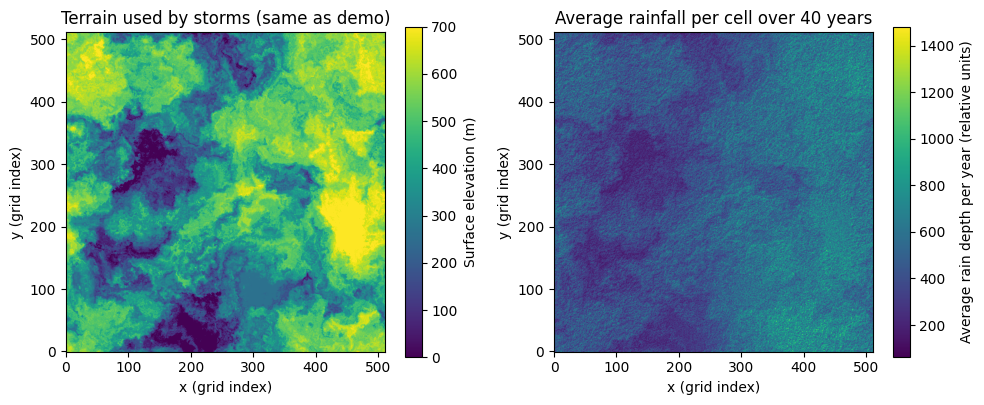

In [10]:
# ============================================================
# RAINFALL SIMULATION + AVERAGE RAIN MAP
# Paste this AFTER all your existing code and run it.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Any, Optional

# ------------------------------------------------------------
# 1. Wrap your quantum_uniforms function in a tiny "module-like"
#    object so Block 5 can call quantum_rng.quantum_uniforms(...)
# ------------------------------------------------------------
class _QuantumRNGWrapper:
    def quantum_uniforms(self, n: int, backend=None, seed_sim: Optional[int] = None):
        # Use the global quantum_uniforms function you already defined
        return quantum_uniforms(n, backend=backend, seed_sim=seed_sim)

# This name is what run_multi_year_weather_simulation expects
quantum_rng = _QuantumRNGWrapper()

# ------------------------------------------------------------
# 2. Year-level storm scheduler (Block 4) using climate trends,
#    duration/gap sampling, and a quantum-seeded NumPy RNG
# ------------------------------------------------------------

def _make_year_rng(backend=None, seed_sim: Optional[int] = None) -> np.random.Generator:
    """
    Create a fast NumPy RNG for one year, seeded from a tiny amount
    of quantum randomness.

    We call quantum_uniforms(2) ONCE, turn those two uniforms into
    a 64-bit integer seed, and then use np.random.default_rng(seed)
    for all storm draws in that year.

    This keeps the "quantum-seeded" flavor but avoids calling Qiskit
    for every single storm.
    """
    # Two [0,1) uniforms from your quantum_uniforms helper
    u = quantum_uniforms(2, backend=backend, seed_sim=seed_sim)
    u = np.asarray(u, dtype=float)

    # Map each uniform to a 32-bit integer and combine
    part1 = int(u[0] * (2**32)) & 0xFFFFFFFF
    part2 = int(u[1] * (2**32)) & 0xFFFFFFFF
    seed = (part1 << 32) ^ part2  # 64-bit seed

    return np.random.default_rng(seed)

def _year_seed_from_quantum(
    year_index: int,
    backend=None,
    seed_sim: Optional[int] = None,
) -> int:
    """
    Use a tiny bit of quantum randomness to generate a 64-bit seed
    for the YEAR-level classical RNG. This gives you quantum seeding
    without calling Qiskit for every single storm.

    We ALSO mix in the year_index so different years get different seeds.
    """
    # Draw 2 quantum uniforms once
    u = quantum_uniforms(2, backend=backend, seed_sim=seed_sim).astype(float)

    # Map each uniform into 32 bits
    part1 = int(u[0] * (2**32)) & 0xFFFFFFFF
    part2 = int(u[1] * (2**32)) & 0xFFFFFFFF

    # Combine into a 64-bit seed
    seed = (part1 << 32) ^ part2

    # Mix in year_index so year 0, 1, 2, ... don't share seeds
    seed ^= (year_index * 0x9E3779B97F4A7C15) & ((1 << 64) - 1)

    return seed & ((1 << 64) - 1)


def generate_storm_schedule_for_year(
    year_index: int,
    year_length_days: float = 365.0,
    max_storms: Optional[int] = None,
    backend=None,
    seed_sim: Optional[int] = None,
) -> List[Dict[str, Any]]:
    """
    Build a storm schedule for one year.

    Uses:
      - get_year_trend(year_index)
      - get_seasonal_modifiers(fraction_of_year)
      - sample_interstorm_gap(...)
      - sample_storm_duration(...)

    NOW:
      - We only use QUANTUM to seed a fast NumPy RNG ONCE per year.
      - Inside the loop, we use rng.random(4), which is much faster.

    Returns a list of storm_event dicts with keys:
      - "year_index"
      - "storm_index"
      - "t_start_day"
      - "t_end_day"
      - "duration_days"
      - "intensity_factor"
      - "preferred_wind_dir_deg"
    """
    # Year-level climate parameters (Block 1)
    year_params = get_year_trend(year_index)

    # Quantum-seeded RNG for this YEAR (fast classical PRNG after this)
    seed_year = _year_seed_from_quantum(year_index, backend=backend, seed_sim=seed_sim)
    rng = np.random.default_rng(seed_year)

    storms: List[Dict[str, Any]] = []
    t = 0.0          # current time in days
    storm_index = 0

    while t < year_length_days:
        # Draw FOUR classical uniforms (much faster than calling Qiskit here):
        #   u_gap -> gap between storms
        #   u_dur -> storm duration
        #   u_int -> extra intensity jitter
        #   u_dir -> wind-direction jitter
        u_gap, u_dur, u_int, u_dir = rng.random(4)

        # Gap and duration from Block 3 samplers
        gap_days = sample_interstorm_gap(year_params, u_gap)
        duration_days = sample_storm_duration(year_params, u_dur)

        t_start = t + gap_days
        if t_start >= year_length_days:
            break

        t_end = min(t_start + duration_days, year_length_days)
        duration_days = t_end - t_start

        # Seasonal modifiers based on where we are in the year
        frac_of_year = (t_start / year_length_days) % 1.0
        season = get_seasonal_modifiers(frac_of_year)

        # Base intensity from climate, modulated by season and jitter
        base_intensity = year_params["mean_storm_intensity_factor"]
        intensity = base_intensity * season["intensity_multiplier"]
        # Extra randomness but keep in a reasonable range
        intensity *= (0.7 + 0.6 * u_int)  # ∈ [0.7, 1.3] of seasonal value

        # Per-storm wind direction (same logic as before)
        base_dir = year_params["preferred_wind_dir_deg"]

        # Seasonal shift: slightly different typical directions in different seasons
        seasonal_shift = 20.0 * np.sin(2.0 * np.pi * frac_of_year)  # ±20°

        # Random jitter: spread storms in a ±40° cone
        rand_shift = (u_dir - 0.5) * 80.0  # [0,1] -> [-40°, +40°]

        storm_dir = (base_dir + seasonal_shift + rand_shift) % 360.0

        storm_event = {
            "year_index": year_index,
            "storm_index": storm_index,
            "t_start_day": float(t_start),
            "t_end_day": float(t_end),
            "duration_days": float(duration_days),
            "intensity_factor": float(intensity),
            "preferred_wind_dir_deg": float(storm_dir),
        }
        storms.append(storm_event)

        # Advance time to end of this storm
        t = t_end
        storm_index += 1

        if max_storms is not None and storm_index >= max_storms:
            break

    return storms


# ------------------------------------------------------------
# 3. RUN THE MULTI-YEAR SIMULATION
# ------------------------------------------------------------

RUN_HEAVY_SIM = True  # set True to run the multi-year simulation

if RUN_HEAVY_SIM:
    # Core settings (you can tweak these)
    NUM_YEARS = 40
    GRID_SIZE = surface_elev.shape[0]   # use the demo terrain size (512 if you used N=512)
    PIXEL_SCALE_KM = 10.0  # size of each cell in km
    YEAR_LENGTH_DAYS = 365.0
    DT_HOURS = 15.0
    import os, time
    SEED_SIM = int.from_bytes(os.urandom(4), "little") ^ (time.time_ns() & 0xFFFFFFFF)

    results = run_multi_year_weather_simulation(
        num_years=NUM_YEARS,
        grid_size=GRID_SIZE,
        pixel_scale_km=PIXEL_SCALE_KM,
        scheduler_fn=generate_storm_schedule_for_year,
        weather_fields_fn=generate_storm_weather_fields,
        quantum_rng_module=quantum_rng,
        accumulate_fn=accumulate_rain_over_simulation,
        terrain_topography_fn=terrain_topography_from_demo,
        stratigraphy_fn=stratigraphy_from_demo,
        year_length_days=YEAR_LENGTH_DAYS,
        temporal_resolution_hours=DT_HOURS,
        backend=None,
        seed_sim=SEED_SIM,
        store_per_year=True,
        store_per_storm=False,
    )

    surface_elev = np.asarray(results["surface_elev"], dtype=float)
    rain_stats   = results["rain_stats"]

    total_rain = np.asarray(rain_stats["total_rain_depth"], dtype=float)
    hit_count  = np.asarray(rain_stats["hit_count"], dtype=float)

    print("Simulation finished.")
    print(f"Total rain depth: min={total_rain.min():.4f}, max={total_rain.max():.4f}")
    print(f"Hit count:        min={hit_count.min():.0f}, max={hit_count.max():.0f}")

    if NUM_YEARS <= 0:
        raise ValueError("NUM_YEARS must be > 0.")

    avg_rain = total_rain / float(NUM_YEARS)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    im0 = plt.imshow(surface_elev, origin="lower")
    plt.title("Terrain used by storms (same as demo)")
    plt.xlabel("x (grid index)")
    plt.ylabel("y (grid index)")
    plt.colorbar(im0, label="Surface elevation (m)")

    plt.subplot(1, 2, 2)
    im1 = plt.imshow(avg_rain, origin="lower")
    plt.title(f"Average rainfall per cell over {NUM_YEARS} years")
    plt.xlabel("x (grid index)")
    plt.ylabel("y (grid index)")
    plt.colorbar(im1, label="Average rain depth per year (relative units)")

    plt.tight_layout()
    plt.show()

